# Signalized Intersection LOS Analysis
This notebook rewrites the original `LOS.py` workflow into a narrated, reproducible analysis. Each section introduces the Highway Capacity Manual (HCM) concepts, loads the required timing and volume inputs, and walks through Level of Service (LOS) calculations for every available intersection. The final cells summarize the results and visualize LOS grades so planners can identify problem locations at a glance.

## Data Inputs and Notebook Flow
- **Phase timing files** (`data/times/*.csv`) provide per-phase green, yellow, and red-clearance durations for each intersection plan.
- **Turning movement volumes** (`data/volume/*.csv`) store 15-minute counts for approach movements such as `NBT`, `EBL`, etc.
- We will: (1) configure directories, (2) define the LOS helper functions from `LOS.py`, (3) compute per-movement and intersection-level metrics, and (4) graph LOS grades for every site.

In [1]:
# Core scientific stack and plotting
import json
import os
from pathlib import Path
from typing import Any, Dict, List, Tuple
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import regex as re

# Display options for concise tables
pd.set_option("display.max_columns", 50)
pd.set_option("display.width", 120)

# Directory configuration (assumes notebook lives in project root)
PROJECT_ROOT = Path.cwd()
PHASE_DIR = PROJECT_ROOT / "data" / "times"
VOLUME_DIR = PROJECT_ROOT / "data" / "volume"
PHASE_DIR, VOLUME_DIR

(PosixPath('/Users/brettberry/Coding/Ignite/COB-Traffic-Project/data/times'),
 PosixPath('/Users/brettberry/Coding/Ignite/COB-Traffic-Project/data/volume'))

## LOS Thresholds and Phase Mapping Helpers
The Highway Capacity Manual (HCM 2010) defines LOS grades from **A (≤10 s/veh)** to **F (>80 s/veh)** based on control delay. We also need to translate NEMA-style phase labels (e.g., `1 EBLT`) into movement codes (`EBL`, `EBT`). The next cell establishes those shared constants and helper utilities.

In [2]:
# LOS thresholds and movement parsing utilities
LOS_THRESHOLDS: Dict[str, Tuple[float, float]] = {
    "A": (0.0, 10.0),
    "B": (10.0, 20.0),
    "C": (20.0, 35.0),
    "D": (35.0, 55.0),
    "E": (55.0, 80.0),
    "F": (80.0, float("inf")),
}

MOVEMENT_COLS = [
    "NBL", "NBT", "NBR",
    "SBL", "SBT", "SBR",
    "EBL", "EBT", "EBR",
    "WBL", "WBT", "WBR",
]

# Default NEMA mapping when timing files only list numeric phase IDs
DEFAULT_PHASE_MOVEMENTS: Dict[str, List[str]] = {
    "1": ["NBL"],
    "2": ["SBL"],
    "3": ["EBL"],
    "4": ["WBL"],
    "5": ["NBT", "NBR"],
    "6": ["SBT", "SBR"],
    "7": ["EBT", "EBR"],
    "8": ["WBT", "WBR"],
}

# ============================================================================
# TIME-OF-DAY PLAN SCHEDULE
# ============================================================================
# Each tuple: (start_time_HHMM, end_time_HHMM, plan_number, period_name)
# Times are in 24-hour format (e.g., 0600 = 6:00 AM, 1845 = 6:45 PM)
#
# Schedule based on City operations:
#   Plan 25: 0600-0645 (Early AM)
#   Plan 28: 0645-0845 (AM Peak)  
#   Plan 46: 0845-1315 (Midday)
#   Plan 61: 1315-1445 (Early PM)
#   Plan 64: 1445-1845 (PM Peak)
# ============================================================================

PLAN_SCHEDULE: List[Tuple[int, int, int, str]] = [
    (600,  645,  25, "Early AM"),
    (645,  845,  28, "AM Peak"),
    (845,  1315, 46, "Midday"),
    (1315, 1445, 61, "Early PM"),
    (1445, 1845, 64, "PM Peak"),
]

def get_plan_for_time(time_hhmm: int) -> Tuple[int, str]:
    """
    Return the appropriate plan number and period name for a given time.
    
    Args:
        time_hhmm: Time in HHMM format (e.g., 1430 for 2:30 PM)
    
    Returns:
        Tuple of (plan_number, period_name)
    """
    for start, end, plan, name in PLAN_SCHEDULE:
        if start <= time_hhmm < end:
            return plan, name
    # Default to Plan 25 for times outside schedule
    return 25, "Off-Peak"


DEFAULT_SATURATION_FLOW = 1900  # veh/hr/ln
DEFAULT_ANALYSIS_PERIOD = 0.25  # hours (15 min)
DEFAULT_INCREMENTAL_DELAY_FACTOR = 0.5
DEFAULT_UPSTREAM_FACTOR = 1.0
DEFAULT_PROGRESSION_FACTOR = 1.0
MAX_DELAY_CAP = 150.0


def determine_los(delay_seconds: float) -> str:
    """Map control delay to LOS grade. Returns 'F' when delay is missing."""
    if delay_seconds is None or np.isnan(delay_seconds):
        return "F"
    for grade, (low, high) in LOS_THRESHOLDS.items():
        if low <= delay_seconds < high:
            return grade
    return "F"


def parse_phase_label(phase_label: str) -> List[str]:
    """Translate strings like '2WB' or bare numeric IDs into movement codes."""
    cleaned = str(phase_label).strip().replace(" ", "").upper()
    if not cleaned or cleaned in {"NOTUSED", "OFFSET"}:
        return []
    numeric_prefix_match = re.match(r"^(\d+)", cleaned)
    numeric_prefix = numeric_prefix_match.group(1) if numeric_prefix_match else ""
    cleaned = re.sub(r"^\d+", "", cleaned)

    if not cleaned:
        return DEFAULT_PHASE_MOVEMENTS.get(numeric_prefix, [])

    if cleaned in {"NB", "SB", "EB", "WB"}:
        return [f"{cleaned}L", f"{cleaned}T", f"{cleaned}R"]
    direction_match = re.match(r"^(NB|SB|EB|WB)", cleaned)
    if not direction_match:
        return DEFAULT_PHASE_MOVEMENTS.get(numeric_prefix, [])
    direction = direction_match.group(1)
    suffix = cleaned[len(direction):]

    if not suffix:
        return [f"{direction}L", f"{direction}T", f"{direction}R"]
    movements: List[str] = []
    for code in ("L", "T", "R"):
        if code in suffix:
            movements.append(f"{direction}{code}")
    if not movements and suffix in {"LT", "TL", "LTR"}:
        return [f"{direction}L", f"{direction}T", f"{direction}R"]
    return movements or [f"{direction}{suffix}"]

# Print the plan schedule for reference
print("Time-of-Day Plan Schedule:")
print("-" * 50)
for start, end, plan, name in PLAN_SCHEDULE:
    start_str = f"{start//100:02d}:{start%100:02d}"
    end_str = f"{end//100:02d}:{end%100:02d}"
    print(f"  {start_str} - {end_str}  →  Plan {plan} ({name})")

Time-of-Day Plan Schedule:
--------------------------------------------------
  06:00 - 06:45  →  Plan 25 (Early AM)
  06:45 - 08:45  →  Plan 28 (AM Peak)
  08:45 - 13:15  →  Plan 46 (Midday)
  13:15 - 14:45  →  Plan 61 (Early PM)
  14:45 - 18:45  →  Plan 64 (PM Peak)


## Parsing Timing Plans
Signal timing CSV files include multiple plans plus yellow and red-clearance data. The function below mirrors `parse_phase_timing_csv` from `LOS.py` and returns cycle length, plan metadata, and movement-specific green times.

In [3]:
def parse_phase_timing_csv(file_path: Path, plan_number: int = 25) -> Dict[str, Any]:
    """Load a phase timing CSV and return movement green times plus notes/warnings."""
    notes: List[str] = []
    warnings: List[str] = []
    filename = file_path.name
    intersection_id = file_path.stem

    try:
        df = pd.read_csv(file_path, header=None)
    except Exception as exc:
        raise RuntimeError(f"Failed to read {filename}: {exc}") from exc

    df = df.dropna(how="all").reset_index(drop=True)

    phase_header_idx = None
    for idx, row in df.iterrows():
        if str(row.iloc[0]).strip().lower() == "phase":
            phase_header_idx = int(idx)
            break
    if phase_header_idx is None:
        raise RuntimeError(f"Phase header row not found in {filename}")

    phase_row = df.iloc[phase_header_idx]
    phase_labels: List[Tuple[int, str]] = []
    offset_col_idx = None
    for col_idx in range(2, len(phase_row)):
        label = str(phase_row.iloc[col_idx]).strip() if pd.notna(phase_row.iloc[col_idx]) else ""
        if not label:
            continue
        if label.lower() == "offset":
            offset_col_idx = col_idx
            break
        phase_labels.append((col_idx, label))
    offset_col_idx = offset_col_idx or len(phase_row)

    plan_rows = []
    yellow_row = None
    red_row = None
    for idx in range(phase_header_idx + 1, len(df)):
        row = df.iloc[idx]
        label = str(row.iloc[0]).strip().lower() if pd.notna(row.iloc[0]) else ""
        if "yellow" in label:
            yellow_row = row
            continue
        if "red" in label:
            red_row = row
            continue
        plan_val = row.iloc[1]
        if pd.notna(plan_val):
            try:
                plan_rows.append((int(float(plan_val)), row))
            except (ValueError, TypeError):
                continue
    if not plan_rows:
        raise RuntimeError(f"No plan rows found in {filename}")

    selected_plan, selected_row = plan_rows[0]
    for plan_val, row in plan_rows:
        if plan_val == plan_number:
            selected_plan, selected_row = plan_val, row
            break
    if selected_plan != plan_number:
        warnings.append(f"Plan {plan_number} missing; using plan {selected_plan}")
    notes.append(f"Using signal timing plan {selected_plan}")

    phases: Dict[str, float] = {}
    for col_idx, label in phase_labels:
        if col_idx >= len(selected_row):
            continue
        try:
            green_time = float(selected_row.iloc[col_idx])
            if green_time > 0:
                phases[label] = green_time
        except (ValueError, TypeError):
            warnings.append(f"Invalid green time for phase {label}")

    yellow_times: Dict[str, float] = {}
    if yellow_row is not None:
        for col_idx, label in phase_labels:
            if col_idx < len(yellow_row):
                try:
                    val = float(yellow_row.iloc[col_idx])
                    if val > 0:
                        yellow_times[label] = val
                except (ValueError, TypeError):
                    continue

    red_times: Dict[str, float] = {}
    if red_row is not None:
        for col_idx, label in phase_labels:
            if col_idx < len(red_row):
                try:
                    val = float(red_row.iloc[col_idx])
                    if val >= 0:
                        red_times[label] = val
                except (ValueError, TypeError):
                    continue

    avg_yellow = np.mean(list(yellow_times.values())) if yellow_times else 4.0
    avg_red = np.mean(list(red_times.values())) if red_times else 1.0
    
    # Get phase greens as a list, preserving order by phase number
    # Sort by numeric prefix if possible (1EBLT, 2WB, etc.)
    sorted_phases = sorted(phases.items(), key=lambda x: (
        int(re.match(r'^(\d+)', x[0]).group(1)) if re.match(r'^(\d+)', x[0]) else 99
    ))
    phase_greens = [g for _, g in sorted_phases]
    num_phases = len(phase_greens)
    
    # Calculate cycle length based on dual-ring 8-phase structure
    # Ring 1: phases 1,2,3,4 | Ring 2: phases 5,6,7,8
    # The cycle is the MAX of ring sums (concurrent phases run together)
    if num_phases >= 8:
        ring1 = sum(phase_greens[:4])  # Phases 1-4
        ring2 = sum(phase_greens[4:8]) # Phases 5-8
        # Cycle = max ring time + clearance for 4 phase transitions
        cycle_length = max(ring1, ring2) + 4 * (avg_yellow + avg_red)
        notes.append(f"Dual-ring cycle: Ring1={ring1:.0f}s, Ring2={ring2:.0f}s")
    elif num_phases >= 4:
        # 4-phase signal: sum first 4 phases + 2 clearance intervals
        cycle_length = sum(phase_greens[:4]) + 2 * (avg_yellow + avg_red)
    else:
        # Simple 2-phase
        cycle_length = sum(phase_greens) + 2 * (avg_yellow + avg_red)
    
    # Read offset value (for informational purposes only)
    # NOTE: Offset is the coordination offset from master, NOT the cycle length!
    # We should NOT substitute offset for cycle length.
    offset_value = None
    if offset_col_idx < len(selected_row):
        try:
            offset_value = float(selected_row.iloc[offset_col_idx])
            notes.append(f"Coordination offset: {offset_value:.0f}s")
        except (ValueError, TypeError):
            offset_value = None

    if cycle_length <= 0:
        raise RuntimeError(f"Computed cycle length is invalid for {filename}")

    movement_green_times: Dict[str, float] = {}
    for phase_label, green_time in phases.items():
        for movement in parse_phase_label(phase_label):
            movement_green_times[movement] = max(green_time, movement_green_times.get(movement, 0))

    notes.append(f"Mapped {len(phases)} phases to {len(movement_green_times)} movements")

    return {
        "intersection_id": intersection_id,
        "plan_used": selected_plan,
        "cycle_length_s": cycle_length,
        "phases": phases,
        "yellow_times": yellow_times,
        "red_clearance_times": red_times,
        "movement_green_times": movement_green_times,
        "notes": notes,
        "warnings": warnings,
    }

## Parsing Turning Movement Volumes
Volume CSVs contain 15-minute observations with occasional blanks or `*`. The parser below mirrors the script by cleaning these inputs, applying either a peak-hour or total-hour aggregation, and returning per-movement hourly volumes.

In [4]:
def parse_volume_csv(
    file_path: Path, 
    aggregation: str = "peak_hour",
    time_filter: Tuple[int, int] = None
) -> Dict[str, Any]:
    """
    Clean turning-movement data and derive hourly volumes per movement.
    
    Args:
        file_path: Path to volume CSV file
        aggregation: "peak_hour" or "total" 
        time_filter: Optional tuple (start_hhmm, end_hhmm) to filter data by time of day
                    e.g., (1200, 1800) for 12:00 PM to 6:00 PM
    
    IMPORTANT: For multi-day data, we compute the peak hour for EACH day,
    then AVERAGE across all days to get representative peak-hour volumes.
    This prevents artificially low LOS ratings from cherry-picking one good hour.
    """
    notes: List[str] = []
    warnings: List[str] = []
    filename = file_path.name
    intersection_id = file_path.stem

    try:
        df = pd.read_csv(file_path, skiprows=2, index_col=False)
    except Exception as exc:
        raise RuntimeError(f"Failed to read {filename}: {exc}") from exc

    df = df.loc[:, ~df.columns.str.contains("^Unnamed")]
    for col in ("DATE", "TIME"):
        if col not in df.columns:
            raise RuntimeError(f"Required column {col} missing in {filename}")

    available_movements = [col for col in MOVEMENT_COLS if col in df.columns]
    if not available_movements:
        raise RuntimeError(f"No movement columns found in {filename}")

    df["TIME"] = df["TIME"].astype(str).str.extract(r"(\d{4})", expand=False)
    missing_values = 0
    for col in available_movements:
        df[col] = pd.to_numeric(df[col].replace("*", np.nan), errors="coerce")
        missing_values += df[col].isna().sum()
    if missing_values:
        notes.append(f"Missing values treated as 0: {missing_values}")
    df[available_movements] = df[available_movements].fillna(0)

    lanes_with_data = [col for col in available_movements if df[col].sum() > 0]
    if not lanes_with_data:
        raise RuntimeError(f"All movement volumes are zero in {filename}")
    lanes_excluded = [col for col in available_movements if col not in lanes_with_data]
    if lanes_excluded:
        notes.append(f"Lanes excluded due to zero volume: {lanes_excluded}")

    # Parse datetime
    try:
        df["TIME"] = df["TIME"].fillna("0000").astype(str).str.zfill(4)
        df["DATE"] = df["DATE"].fillna("").astype(str)
        valid_mask = (df["DATE"].str.len() > 0) & (df["TIME"].str.len() == 4)
        df_valid = df[valid_mask].copy()
        if not df_valid.empty:
            df_valid["DateTime"] = pd.to_datetime(
                df_valid["DATE"] + " " + df_valid["TIME"],
                format="%m/%d/%Y %H%M",
                errors="coerce",
            )
            df = df_valid.dropna(subset=["DateTime"]).sort_values("DateTime").copy()
            df["DateOnly"] = df["DateTime"].dt.date
            df["Hour"] = df["DateTime"].dt.hour
            df["TimeHHMM"] = df["DateTime"].dt.hour * 100 + df["DateTime"].dt.minute
        else:
            warnings.append("No valid DATE/TIME rows found; using index order")
            df["DateTime"] = pd.RangeIndex(len(df))
            df["DateOnly"] = 0
            df["Hour"] = 0
            df["TimeHHMM"] = 0
    except Exception as exc:
        warnings.append(f"Datetime parsing failed: {exc}")
        df["DateTime"] = pd.RangeIndex(len(df))
        df["DateOnly"] = 0
        df["Hour"] = 0
        df["TimeHHMM"] = 0

    # Apply time filter if specified
    if time_filter is not None:
        start_time, end_time = time_filter
        original_count = len(df)
        df = df[(df["TimeHHMM"] >= start_time) & (df["TimeHHMM"] < end_time)].copy()
        filtered_count = len(df)
        
        start_str = f"{start_time//100:02d}:{start_time%100:02d}"
        end_str = f"{end_time//100:02d}:{end_time%100:02d}"
        notes.append(f"Time filter: {start_str}-{end_str} ({filtered_count}/{original_count} intervals)")
        
        if df.empty:
            warnings.append(f"No data in time range {start_str}-{end_str}")
            return {
                "intersection_id": intersection_id,
                "volumes_vph": {},
                "peak_hour_start": None,
                "total_intervals": 0,
                "lanes_with_data": [],
                "notes": notes,
                "warnings": warnings,
            }
        
        # Update lanes_with_data based on filtered data
        lanes_with_data = [col for col in lanes_with_data if df[col].sum() > 0]

    total_intervals = len(df)
    unique_dates = df["DateOnly"].nunique()
    notes.append(f"Total 15-minute intervals: {total_intervals} across {unique_dates} days")
    
    volumes_vph: Dict[str, int] = {}
    peak_hour_start = None

    if aggregation == "peak_hour" and total_intervals >= 4:
        # Find peak hour PER DAY, then AVERAGE across all days
        daily_peak_volumes: Dict[str, List[int]] = {col: [] for col in lanes_with_data}
        peak_hours_found: List[str] = []
        
        for date_val, day_df in df.groupby("DateOnly"):
            if len(day_df) < 4:
                continue
            
            day_df = day_df.sort_values("DateTime").reset_index(drop=True)
            day_df["TotalVol"] = day_df[lanes_with_data].sum(axis=1)
            
            # Find the peak hour (4 consecutive 15-min intervals) for this day
            best_sum = 0
            best_start_idx = 0
            for i in range(len(day_df) - 3):
                window_sum = day_df["TotalVol"].iloc[i:i+4].sum()
                if window_sum > best_sum:
                    best_sum = window_sum
                    best_start_idx = i
            
            peak_df = day_df.iloc[best_start_idx:best_start_idx + 4]
            
            if "DateTime" in day_df.columns and not peak_df.empty:
                peak_dt = peak_df["DateTime"].iloc[0]
                if pd.notna(peak_dt):
                    peak_hours_found.append(f"{date_val} {peak_dt.strftime('%H:%M')}")
            
            for col in lanes_with_data:
                daily_peak_volumes[col].append(int(peak_df[col].sum()))
        
        if not any(daily_peak_volumes.values()) or not daily_peak_volumes[lanes_with_data[0]]:
            warnings.append("No complete days found for peak hour analysis")
            total_hours = total_intervals * 0.25 or 1.0
            for col in lanes_with_data:
                volumes_vph[col] = int(df[col].sum() / total_hours)
        else:
            num_days = len(daily_peak_volumes[lanes_with_data[0]])
            for col in lanes_with_data:
                avg_peak_vol = sum(daily_peak_volumes[col]) / len(daily_peak_volumes[col])
                volumes_vph[col] = int(round(avg_peak_vol))
            
            notes.append(f"Averaged peak-hour volumes across {num_days} days")
            if peak_hours_found:
                sample = peak_hours_found[:3]
                if len(peak_hours_found) > 3:
                    sample.append(f"...and {len(peak_hours_found)-3} more")
                peak_hour_start = f"Multiple days: {', '.join(sample)}"
    else:
        # Total aggregation - average hourly rate across all data
        total_hours = total_intervals * 0.25 or 1.0
        for col in lanes_with_data:
            volumes_vph[col] = int(df[col].sum() / total_hours)
        notes.append(f"Using total volume over {total_hours:.1f} hours as hourly rate")

    return {
        "intersection_id": intersection_id,
        "volumes_vph": volumes_vph,
        "peak_hour_start": peak_hour_start,
        "total_intervals": total_intervals,
        "lanes_with_data": lanes_with_data,
        "notes": notes,
        "warnings": warnings,
    }

## Control Delay and Intersection-Level LOS
With timing and volume inputs parsed, the next utilities implement the simplified HCM control-delay equation plus the weighted-average LOS rollup. These functions are direct notebook equivalents of `compute_control_delay` and `compute_intersection_los` from the script.

In [5]:
def compute_control_delay(
    volume_vph: float,
    saturation_flow: float,
    green_time_s: float,
    cycle_length_s: float,
    analysis_period_h: float = DEFAULT_ANALYSIS_PERIOD,
    k_factor: float = DEFAULT_INCREMENTAL_DELAY_FACTOR,
    i_factor: float = DEFAULT_UPSTREAM_FACTOR,
    progression_factor: float = DEFAULT_PROGRESSION_FACTOR,
) -> Tuple[float, float, float]:
    """
    Apply the HCM 2010 control delay equation.
    
    d = d1 * PF + d2 + d3
    
    Where:
      d1 = uniform delay
      d2 = incremental (random + overflow) delay  
      d3 = initial queue delay (assumed 0)
      PF = progression factor (1.0 for random arrivals / isolated signal)
    
    For pre-timed signals at isolated intersections, this provides
    a conservative estimate of average control delay per vehicle.
    """
    if cycle_length_s <= 0 or green_time_s <= 0 or saturation_flow <= 0:
        return (MAX_DELAY_CAP, float("inf"), 0.0)
    
    g_over_c = green_time_s / cycle_length_s
    if g_over_c <= 0:
        return (MAX_DELAY_CAP, float("inf"), g_over_c)
    if g_over_c > 1.0:
        g_over_c = 1.0  # Cap at 100% green
    
    # Capacity = saturation flow * effective green ratio
    capacity = saturation_flow * g_over_c
    if capacity <= 0:
        return (MAX_DELAY_CAP, float("inf"), g_over_c)
    
    # Degree of saturation (volume-to-capacity ratio)
    degree_of_saturation = volume_vph / capacity
    
    # ----- d1: Uniform Delay (HCM Equation 18-20) -----
    # d1 = 0.5 * C * (1 - g/C)^2 / (1 - min(1,X) * g/C)
    numerator = 0.5 * cycle_length_s * (1 - g_over_c) ** 2
    denominator = 1 - min(1.0, degree_of_saturation) * g_over_c
    
    if denominator <= 0.01:
        # Near or at saturation - use high delay
        d1 = 0.5 * cycle_length_s * (1 - g_over_c)  # Simplified max uniform delay
    else:
        d1 = numerator / denominator
    
    # ----- d2: Incremental Delay (HCM Equation 18-21) -----
    # d2 = 900 * T * [(X-1) + sqrt((X-1)^2 + 8*k*I*X / (c*T))]
    # 
    # This accounts for random arrivals and overflow queuing
    T = analysis_period_h  # Analysis period in hours
    c_T = capacity * T  # Capacity during analysis period (vehicles)
    
    if c_T <= 0:
        d2 = MAX_DELAY_CAP
    else:
        X = degree_of_saturation
        inner_term = (X - 1) ** 2 + (8 * k_factor * i_factor * X) / c_T
        d2 = 900 * T * ((X - 1) + np.sqrt(max(0.0, inner_term)))
    
    # ----- d3: Initial Queue Delay -----
    # Assumed 0 for this analysis (no residual queues from prior periods)
    d3 = 0.0
    
    # ----- Total Control Delay -----
    total_delay = d1 * progression_factor + d2 + d3
    
    # Apply reasonable bounds
    total_delay = max(0.0, min(MAX_DELAY_CAP, total_delay))
    
    return (total_delay, degree_of_saturation, g_over_c)


def compute_intersection_los(per_lane_results: List[Dict[str, Any]]) -> Dict[str, Any]:
    """
    Aggregate per-movement delay into volume-weighted intersection LOS.
    
    HCM methodology: The intersection-level delay is the volume-weighted
    average of all approach/movement delays. This ensures high-volume
    movements have proportionally greater influence on the overall grade.
    """
    total_volume = 0.0
    weighted_delay = 0.0
    
    for lane in per_lane_results:
        volume = lane.get("volume_vph", 0) or 0
        delay = lane.get("delay_s_per_veh")
        
        if delay is not None and volume > 0:
            total_volume += volume
            weighted_delay += volume * delay
    
    if total_volume > 0:
        avg_delay = weighted_delay / total_volume
    else:
        avg_delay = 0.0
    
    return {
        "average_delay_s_per_veh": round(avg_delay, 2),
        "LOS": determine_los(avg_delay),
        "total_volume_vph": int(total_volume),
    }

## Putting It Together: Intersection and Corridor Evaluations
The next block recreates `compute_los_for_intersection` and directory helpers so we can evaluate either individual file pairs or every matched intersection in the project folders.

In [6]:
def get_green_time_for_movement(
    movement: str,
    movement_greens: Dict[str, float],
    cycle_length: float
) -> Tuple[float, str]:
    """
    Find the appropriate green time for a movement.
    
    Strategy:
    1. Direct match (e.g., NBT -> NBT)
    2. Direction match (e.g., NBT -> any NB phase)
    3. Opposing through movement (e.g., NBT uses SBT green if coordinated)
    4. Default minimum green (15s) as last resort
    
    Returns (green_time, match_type)
    """
    # Direct match
    if movement in movement_greens:
        return movement_greens[movement], "direct"
    
    direction = movement[:2]  # NB, SB, EB, WB
    move_type = movement[2] if len(movement) > 2 else "T"  # L, T, R
    
    # Find any green for same direction
    direction_greens = []
    for mov, g in movement_greens.items():
        if mov.startswith(direction):
            direction_greens.append(g)
    
    if direction_greens:
        # Use the maximum green for this direction (typically through movement)
        return max(direction_greens), "direction"
    
    # For through movements, check opposing direction (coordinated signals)
    if move_type == "T":
        opposing = {"NB": "SB", "SB": "NB", "EB": "WB", "WB": "EB"}
        opp_dir = opposing.get(direction, "")
        for mov, g in movement_greens.items():
            if mov.startswith(opp_dir) and "T" in mov:
                return g, "opposing"
    
    # Last resort: use a conservative default (about 20% of typical cycle)
    default_green = max(15.0, cycle_length * 0.15)
    return default_green, "default"


def compute_los_for_intersection(
    phase_csv: Path,
    volume_csv: Path,
    saturation_flow: int = DEFAULT_SATURATION_FLOW,
    plan_number: int = 25,
    aggregation: str = "peak_hour",
    time_filter: Tuple[int, int] = None,
) -> Dict[str, Any]:
    """
    Compute LOS for an intersection using HCM methodology.
    
    Args:
        phase_csv: Path to phase timing CSV
        volume_csv: Path to volume CSV
        saturation_flow: Saturation flow rate (veh/hr/lane)
        plan_number: Signal timing plan number to use
        aggregation: "peak_hour" or "total"
        time_filter: Optional (start_hhmm, end_hhmm) to filter volumes by time
    
    All movements with volume are evaluated. When exact phase-to-movement
    matches aren't found, we use direction-based matching to ensure
    realistic delay calculations.
    """
    timing = parse_phase_timing_csv(phase_csv, plan_number=plan_number)
    volume = parse_volume_csv(volume_csv, aggregation=aggregation, time_filter=time_filter)

    per_lane_results: List[Dict[str, Any]] = []
    cycle_length = timing["cycle_length_s"]
    movement_greens = timing.get("movement_green_times", {})
    
    match_notes = []
    
    for movement, volume_vph in volume["volumes_vph"].items():
        if volume_vph <= 0:
            continue
        
        green_time, match_type = get_green_time_for_movement(
            movement, movement_greens, cycle_length
        )
        
        if match_type == "default":
            match_notes.append(f"{movement}: using default green {green_time:.0f}s")
        elif match_type != "direct":
            match_notes.append(f"{movement}: matched via {match_type}")
        
        delay, degree_of_saturation, g_over_c = compute_control_delay(
            volume_vph=volume_vph,
            saturation_flow=saturation_flow,
            green_time_s=green_time,
            cycle_length_s=cycle_length,
        )
        
        per_lane_results.append({
            "movement": movement,
            "volume_vph": volume_vph,
            "saturation_flow_vphpl": saturation_flow,
            "g_s": round(green_time, 1),
            "g_over_C": round(g_over_c, 3),
            "degree_of_saturation": round(degree_of_saturation, 3),
            "delay_s_per_veh": round(delay, 1),
            "LOS": determine_los(delay),
            "match_type": match_type,
        })

    intersection_summary = compute_intersection_los(per_lane_results)
    
    notes = timing.get("notes", []) + volume.get("notes", [])
    if match_notes:
        notes.append(f"Green time matching: {len(match_notes)} movements required inference")
    
    return {
        "intersection_id": timing["intersection_id"],
        "source_files": {
            "phase_file": phase_csv.name,
            "volume_file": volume_csv.name,
        },
        "cycle_length_s": round(cycle_length, 1),
        "plan_used": timing["plan_used"],
        "per_lane": per_lane_results,
        "intersection": intersection_summary,
        "parameters": {
            "saturation_flow_vphpl": saturation_flow,
            "aggregation": aggregation,
            "time_filter": time_filter,
        },
        "notes": notes,
        "warnings": timing.get("warnings", []) + volume.get("warnings", []),
    }


def compute_los_for_directories(
    phase_dir: Path,
    volume_dir: Path,
    saturation_flow: int = DEFAULT_SATURATION_FLOW,
    aggregation: str = "peak_hour",
    plan_number: int = 25,
    time_filter: Tuple[int, int] = None,
) -> Dict[str, Any]:
    """Match files by intersection id and run LOS for the entire data set."""
    phase_files = {path.stem: path for path in phase_dir.glob("*.csv")}
    volume_files = {path.stem: path for path in volume_dir.glob("*.csv")}
    all_ids = sorted(set(phase_files) | set(volume_files))
    results: Dict[str, Any] = {}
    for intersection_id in all_ids:
        phase_path = phase_files.get(intersection_id)
        volume_path = volume_files.get(intersection_id)
        if not phase_path or not volume_path:
            results[intersection_id] = {
                "intersection_id": intersection_id,
                "error": "Missing phase or volume file",
            }
            continue
        try:
            results[intersection_id] = compute_los_for_intersection(
                phase_path,
                volume_path,
                saturation_flow=saturation_flow,
                plan_number=plan_number,
                aggregation=aggregation,
                time_filter=time_filter,
            )
        except Exception as exc:
            results[intersection_id] = {
                "intersection_id": intersection_id,
                "error": str(exc),
            }
    summary = {
        "total_intersections": len(results),
        "successful": sum(1 for r in results.values() if "error" not in r),
        "failed": sum(1 for r in results.values() if "error" in r),
    }
    return {
        "intersections": results,
        "summary": summary,
        "parameters": {
            "saturation_flow_vphpl": saturation_flow,
            "aggregation": aggregation,
            "plan_number": plan_number,
            "time_filter": time_filter,
        },
    }


def compute_los_by_time_period(
    phase_dir: Path,
    volume_dir: Path,
    saturation_flow: int = DEFAULT_SATURATION_FLOW,
    aggregation: str = "peak_hour",
) -> Dict[str, Any]:
    """
    Compute LOS for each time-of-day period using the appropriate signal plan.
    
    Uses the PLAN_SCHEDULE to match volume data from each time period
    with the correct signal timing plan that was active during that period.
    
    Returns a dictionary with results for each time period plus a combined summary.
    """
    phase_files = {path.stem: path for path in phase_dir.glob("*.csv")}
    volume_files = {path.stem: path for path in volume_dir.glob("*.csv")}
    all_ids = sorted(set(phase_files) & set(volume_files))
    
    period_results: Dict[str, Dict[str, Any]] = {}
    
    for start_time, end_time, plan_number, period_name in PLAN_SCHEDULE:
        time_filter = (start_time, end_time)
        
        results: Dict[str, Any] = {}
        for intersection_id in all_ids:
            phase_path = phase_files.get(intersection_id)
            volume_path = volume_files.get(intersection_id)
            
            try:
                results[intersection_id] = compute_los_for_intersection(
                    phase_path,
                    volume_path,
                    saturation_flow=saturation_flow,
                    plan_number=plan_number,
                    aggregation=aggregation,
                    time_filter=time_filter,
                )
            except Exception as exc:
                results[intersection_id] = {
                    "intersection_id": intersection_id,
                    "error": str(exc),
                }
        
        start_str = f"{start_time//100:02d}:{start_time%100:02d}"
        end_str = f"{end_time//100:02d}:{end_time%100:02d}"
        
        period_results[period_name] = {
            "intersections": results,
            "time_range": f"{start_str}-{end_str}",
            "plan_number": plan_number,
            "summary": {
                "total": len(results),
                "successful": sum(1 for r in results.values() if "error" not in r),
                "failed": sum(1 for r in results.values() if "error" in r),
            }
        }
    
    return {
        "periods": period_results,
        "plan_schedule": PLAN_SCHEDULE,
        "intersection_ids": all_ids,
    }


def summarize_time_period_results(tod_results: Dict[str, Any]) -> pd.DataFrame:
    """
    Create a summary DataFrame showing LOS for each intersection across all time periods.
    """
    records = []
    
    for period_name, period_data in tod_results["periods"].items():
        time_range = period_data["time_range"]
        plan_num = period_data["plan_number"]
        
        for int_id, payload in period_data["intersections"].items():
            if "error" in payload:
                records.append({
                    "period": period_name,
                    "time_range": time_range,
                    "plan": plan_num,
                    "intersection": int_id,
                    "LOS": "ERR",
                    "delay_s": None,
                    "volume_vph": None,
                    "cycle_s": None,
                })
            else:
                summary = payload["intersection"]
                records.append({
                    "period": period_name,
                    "time_range": time_range,
                    "plan": plan_num,
                    "intersection": int_id,
                    "LOS": summary["LOS"],
                    "delay_s": summary["average_delay_s_per_veh"],
                    "volume_vph": summary["total_volume_vph"],
                    "cycle_s": payload.get("cycle_length_s"),
                })
    
    return pd.DataFrame(records)

## Run LOS Computations
Execute the next cell whenever you want fresh LOS results. It scans `data/times` and `data/volume`, matches files by intersection name, and returns both the raw structured output and a DataFrame ready for reporting or plotting.

In [7]:
def intersections_to_dataframe(results: Dict[str, Any]) -> pd.DataFrame:
    """Flatten the LOS dictionary into a tidy DataFrame."""
    records: List[Dict[str, Any]] = []
    for intersection_id, payload in results.get("intersections", {}).items():
        if "error" in payload:
            records.append({
                "intersection_id": intersection_id,
                "error": payload["error"],
            })
            continue
        summary = payload["intersection"]
        records.append({
            "intersection_id": intersection_id,
            "average_delay_s": summary["average_delay_s_per_veh"],
            "LOS": summary["LOS"],
            "total_volume_vph": summary["total_volume_vph"],
            "cycle_length_s": payload["cycle_length_s"],
            "plan_used": payload["plan_used"],
        })
    return pd.DataFrame(records)


def print_detailed_results(results: Dict[str, Any]) -> None:
    """Print detailed per-movement results for debugging LOS calculations."""
    print("=" * 90)
    print("DETAILED LOS ANALYSIS (Multi-Day Averaged Peak Hour)")
    print("=" * 90)
    
    for int_id, payload in sorted(results.get("intersections", {}).items()):
        print(f"\n{'─' * 70}")
        print(f"Intersection: {int_id}")
        
        if "error" in payload:
            print(f"  ERROR: {payload['error']}")
            continue
        
        summary = payload["intersection"]
        print(f"  Cycle Length: {payload['cycle_length_s']:.1f}s | Plan: {payload['plan_used']}")
        print(f"  Intersection LOS: {summary['LOS']} | Avg Delay: {summary['average_delay_s_per_veh']:.1f}s")
        print(f"  Total Volume: {summary['total_volume_vph']:,} vph")
        
        # Show per-movement breakdown
        print(f"\n  {'Movement':<8} {'Vol':<7} {'Green':<7} {'g/C':<7} {'v/c':<7} {'Delay':<8} {'LOS':<4} {'Match':<10}")
        print(f"  {'-'*65}")
        
        for lane in sorted(payload.get("per_lane", []), key=lambda x: x.get("movement", "")):
            mov = lane.get("movement", "?")
            vol = lane.get("volume_vph", 0)
            g_s = lane.get("g_s", "-")
            g_c = lane.get("g_over_C", "-")
            vc = lane.get("degree_of_saturation", "-")
            delay = lane.get("delay_s_per_veh", "-")
            los = lane.get("LOS", "-")
            match = lane.get("match_type", "?")
            
            g_s_str = f"{g_s:.0f}s" if isinstance(g_s, float) else str(g_s)
            g_c_str = f"{g_c:.2f}" if isinstance(g_c, float) else str(g_c)
            vc_str = f"{vc:.2f}" if isinstance(vc, float) else str(vc)
            delay_str = f"{delay:.1f}s" if isinstance(delay, float) else str(delay)
            
            print(f"  {mov:<8} {vol:<7} {g_s_str:<7} {g_c_str:<7} {vc_str:<7} {delay_str:<8} {los:<4} {match:<10}")


los_results = compute_los_for_directories(
    phase_dir=PHASE_DIR,
    volume_dir=VOLUME_DIR,
    saturation_flow=DEFAULT_SATURATION_FLOW,
    aggregation="peak_hour",
    plan_number=25,
)
los_df = intersections_to_dataframe(los_results)

# Show summary
print(f"\nSummary: {los_results['summary']}")
print(f"\nLOS Distribution:")
print(los_df.sort_values("intersection_id")[["intersection_id", "average_delay_s", "LOS", "total_volume_vph"]].to_string(index=False))

# Show detailed breakdown for one intersection to verify
print("\n")
print_detailed_results(los_results)

/var/folders/v4/6t9d5wws7d96w7cqfgjkpyw80000gn/T/ipykernel_76340/1481507317.py:41: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df[col] = pd.to_numeric(df[col].replace("*", np.nan), errors="coerce")
/var/folders/v4/6t9d5wws7d96w7cqfgjkpyw80000gn/T/ipykernel_76340/1481507317.py:41: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df[col] = pd.to_numeric(df[col].replace("*", np.nan), errors="coerce")
/var/folders/v4/6t9d5wws7d96w7cqfgjkpyw80000gn/T/ipykernel_76340/1481507317.py:41: FutureWarning: Downcasting behavior in `replace` is d


Summary: {'total_intersections': 10, 'successful': 10, 'failed': 0}

LOS Distribution:
intersection_id  average_delay_s LOS  total_volume_vph
          102_A           100.49   F              3120
       102_Been            80.34   F              3130
          102_C           125.77   F              2513
        102_Elm            94.27   F              2830
 102_Greenhouse           128.05   F              3312
          102_I            91.32   F              3806
          102_J            51.45   D              3443
    102_Moberly            86.32   F              2483
          102_P           130.16   F              2249
     102_Walton            82.37   F              4107


DETAILED LOS ANALYSIS (Multi-Day Averaged Peak Hour)

──────────────────────────────────────────────────────────────────────
Intersection: 102_A
  Cycle Length: 161.0s | Plan: 25
  Intersection LOS: F | Avg Delay: 100.5s
  Total Volume: 3,120 vph

  Movement Vol     Green   g/C     v/c     Delay    LOS  

In [8]:
# Detailed diagnostic for 102_Elm (was LOS A, now LOS F)
int_id = "102_Elm"
payload = los_results["intersections"][int_id]

print(f"Detailed analysis for {int_id}")
print("=" * 70)
print(f"Cycle length: {payload['cycle_length_s']:.1f}s")
print(f"Intersection LOS: {payload['intersection']['LOS']} ({payload['intersection']['average_delay_s_per_veh']:.1f}s)")
print()

print("Per-Movement Breakdown:")
print(f"{'Mov':<6} {'Vol':<6} {'Green':<7} {'g/C':<7} {'v/c':<7} {'Delay':<8} {'LOS':<4}")
print("-" * 55)

for lane in sorted(payload.get("per_lane", []), key=lambda x: -x.get("volume_vph", 0)):
    mov = lane.get("movement", "?")
    vol = lane.get("volume_vph", 0)
    g = lane.get("g_s", 0)
    gc = lane.get("g_over_C", 0)
    vc = lane.get("degree_of_saturation", 0)
    delay = lane.get("delay_s_per_veh", 0)
    los = lane.get("LOS", "?")
    print(f"{mov:<6} {vol:<6} {g:<7.1f} {gc:<7.3f} {vc:<7.3f} {delay:<8.1f} {los:<4}")

# Also show the raw timing data
print("\n" + "=" * 70)
timing = parse_phase_timing_csv(PHASE_DIR / f"{int_id}.csv", plan_number=25)
print(f"Raw phases: {timing['phases']}")
print(f"Movement greens: {timing['movement_green_times']}")
print(f"Notes: {timing['notes']}")

Detailed analysis for 102_Elm
Cycle length: 150.3s
Intersection LOS: F (94.3s)

Per-Movement Breakdown:
Mov    Vol    Green   g/C     v/c     Delay    LOS 
-------------------------------------------------------
WBT    1068   45.0    0.299   1.877   150.0    F   
EBT    971    74.0    0.492   1.038   77.9     E   
SBL    288    33.0    0.220   0.690   63.0     E   
EBL    266    74.0    0.492   0.284   23.3     C   
SBR    237    66.0    0.439   0.284   27.9     C   

Raw phases: {'1EBLT': 29.0, '2WB': 45.0, '3SBLT': 33.0, '4(Not used)': 33.0, '6EB': 74.0, '8SBRT': 66.0}
Movement greens: {'EBL': 74.0, 'EBT': 74.0, 'WBL': 45.0, 'WBT': 45.0, 'WBR': 45.0, 'SBL': 33.0, 'SBT': 66.0, 'EBR': 74.0, 'SBR': 66.0}
Notes: ['Using signal timing plan 25', 'Coordination offset: 31s', 'Mapped 6 phases to 9 movements']


## Visualize LOS Grades
To spot under-performing intersections quickly, convert LOS letters to an ordinal scale (A→1 … F→6) and plot them. Bars are color-coded by LOS bands; intersections without valid calculations are highlighted separately.

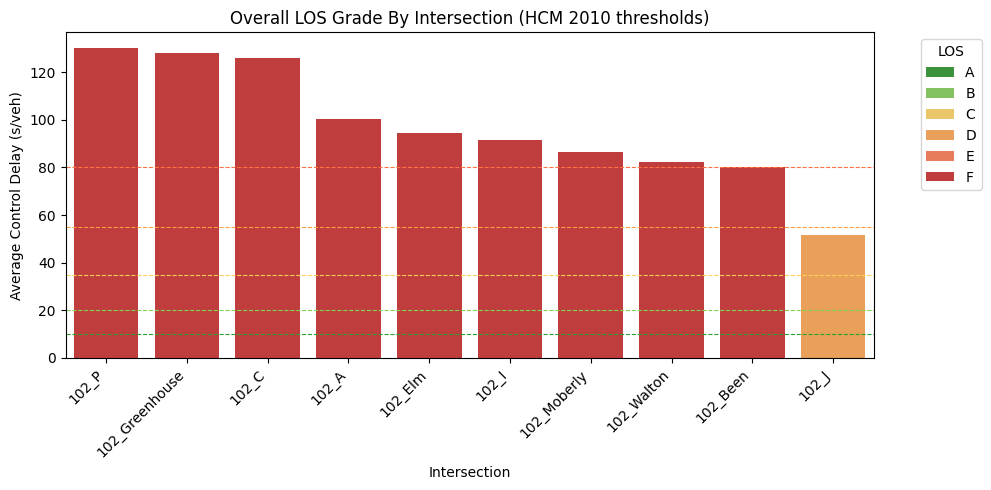

In [9]:
def plot_los_barchart(los_table: pd.DataFrame) -> None:
    """Render LOS grades per intersection using categorical ordering."""
    if los_table.empty:
        print("No LOS results available to plot.")
        return
    order = ["A", "B", "C", "D", "E", "F"]
    los_table = los_table.copy()
    los_table["LOS"] = pd.Categorical(los_table["LOS"], categories=order, ordered=True)
    # Sort by average delay descending (worst to best)
    los_table = los_table.sort_values("average_delay_s", ascending=False)

    palette = {
        "A": "#2ca02c",
        "B": "#7fd34e",
        "C": "#ffcf56",
        "D": "#ff9f43",
        "E": "#ff7043",
        "F": "#d62728",
    }
    plt.figure(figsize=(10, 5))
    sns.barplot(
        data=los_table,
        x="intersection_id",
        y="average_delay_s",
        hue="LOS",
        palette=palette,
        dodge=False,
    )
    plt.axhline(10, color="#2ca02c", linestyle="--", linewidth=0.8)
    plt.axhline(20, color="#7fd34e", linestyle="--", linewidth=0.8)
    plt.axhline(35, color="#ffcf56", linestyle="--", linewidth=0.8)
    plt.axhline(55, color="#ff9f43", linestyle="--", linewidth=0.8)
    plt.axhline(80, color="#ff7043", linestyle="--", linewidth=0.8)
    plt.ylabel("Average Control Delay (s/veh)")
    plt.xlabel("Intersection")
    plt.title("Overall LOS Grade By Intersection (HCM 2010 thresholds)")
    plt.xticks(rotation=45, ha="right")
    plt.legend(title="LOS", bbox_to_anchor=(1.05, 1), loc="upper left")
    plt.tight_layout()
    plt.show()


plot_los_barchart(los_df.dropna(subset=["LOS"]))

## Time-of-Day LOS Analysis by Plan Period
The signal timing uses different plans throughout the day to accommodate varying traffic patterns:

| Period | Time | Plan | Description |
|--------|------|------|-------------|
| Early AM | 06:00-06:45 | Plan 25 | Early morning before rush |
| AM Peak | 06:45-08:45 | Plan 28 | Morning commute |
| Midday | 08:45-13:15 | Plan 46 | Late morning / lunch |
| Early PM | 13:15-14:45 | Plan 61 | Early afternoon |
| PM Peak | 14:45-18:45 | Plan 64 | Evening commute |

The following analysis computes LOS for each time period using the **correct signal plan** that was active during that period, providing a complete picture of intersection performance throughout the day.

In [10]:
# Compute LOS for each time-of-day period using the appropriate signal plan
print("Computing LOS for each time-of-day period...")
print("=" * 80)

tod_results = compute_los_by_time_period(
    phase_dir=PHASE_DIR,
    volume_dir=VOLUME_DIR,
    saturation_flow=DEFAULT_SATURATION_FLOW,
    aggregation="peak_hour",
)

# Create summary DataFrame
tod_summary_df = summarize_time_period_results(tod_results)

# Display summary for each period
print("\nLOS SUMMARY BY TIME PERIOD")
print("=" * 80)

for period_name in ["Early AM", "AM Peak", "Midday", "Early PM", "PM Peak"]:
    if period_name not in tod_results["periods"]:
        continue
    
    period_data = tod_results["periods"][period_name]
    time_range = period_data["time_range"]
    plan_num = period_data["plan_number"]
    
    # Get period subset
    period_df = tod_summary_df[tod_summary_df["period"] == period_name].copy()
    period_df = period_df.dropna(subset=["delay_s"])
    
    if period_df.empty:
        print(f"\n{period_name} ({time_range}) - Plan {plan_num}: No data available")
        continue
    
    # Calculate stats
    avg_delay = period_df["delay_s"].mean()
    avg_los = period_df["LOS"].mode().iloc[0] if not period_df["LOS"].mode().empty else "N/A"
    total_vol = period_df["volume_vph"].sum()
    los_f_count = (period_df["LOS"] == "F").sum()
    
    print(f"\n{period_name} ({time_range}) - Plan {plan_num}")
    print("-" * 60)
    print(f"  Average Delay: {avg_delay:.1f} s/veh")
    print(f"  Total Volume: {total_vol:,} vph")
    print(f"  Intersections at LOS F: {los_f_count} of {len(period_df)}")
    print(f"\n  {'Intersection':<18} {'Delay':<10} {'LOS':<5} {'Volume':<12} {'Cycle':<8}")
    print(f"  {'-'*55}")
    for _, row in period_df.sort_values("delay_s", ascending=False).iterrows():
        print(f"  {row['intersection']:<18} {row['delay_s']:<10.1f} {row['LOS']:<5} "
              f"{row['volume_vph']:<12,.0f} {row['cycle_s']:<8.0f}")

print("\n" + "=" * 80)
print("Time-of-day analysis complete.")

Computing LOS for each time-of-day period...


/var/folders/v4/6t9d5wws7d96w7cqfgjkpyw80000gn/T/ipykernel_76340/1481507317.py:41: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df[col] = pd.to_numeric(df[col].replace("*", np.nan), errors="coerce")
/var/folders/v4/6t9d5wws7d96w7cqfgjkpyw80000gn/T/ipykernel_76340/1481507317.py:41: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df[col] = pd.to_numeric(df[col].replace("*", np.nan), errors="coerce")
/var/folders/v4/6t9d5wws7d96w7cqfgjkpyw80000gn/T/ipykernel_76340/1481507317.py:41: FutureWarning: Downcasting behavior in `replace` is d


LOS SUMMARY BY TIME PERIOD

Early AM (06:00-06:45) - Plan 25
------------------------------------------------------------
  Average Delay: 47.9 s/veh
  Total Volume: 11,969 vph
  Intersections at LOS F: 1 of 10

  Intersection       Delay      LOS   Volume       Cycle   
  -------------------------------------------------------
  102_Greenhouse     104.1      F     1,479        132     
  102_C              67.7       E     1,180        150     
  102_P              44.9       D     905          150     
  102_Moberly        42.6       D     850          161     
  102_I              40.6       D     1,408        160     
  102_J              39.1       D     1,328        163     
  102_Elm            38.1       D     1,312        150     
  102_Walton         37.5       D     1,248        161     
  102_A              36.3       D     1,164        161     
  102_Been           27.8       C     1,095        165     

AM Peak (06:45-08:45) - Plan 28
------------------------------------

/var/folders/v4/6t9d5wws7d96w7cqfgjkpyw80000gn/T/ipykernel_76340/645023637.py:33: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  pivot_delay = df.pivot_table(index="intersection", columns="period", values="delay_s", aggfunc="first")
/var/folders/v4/6t9d5wws7d96w7cqfgjkpyw80000gn/T/ipykernel_76340/645023637.py:71: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  pivot_los = df.pivot_table(index="intersection", columns="period", values="LOS_num", aggfunc="first")


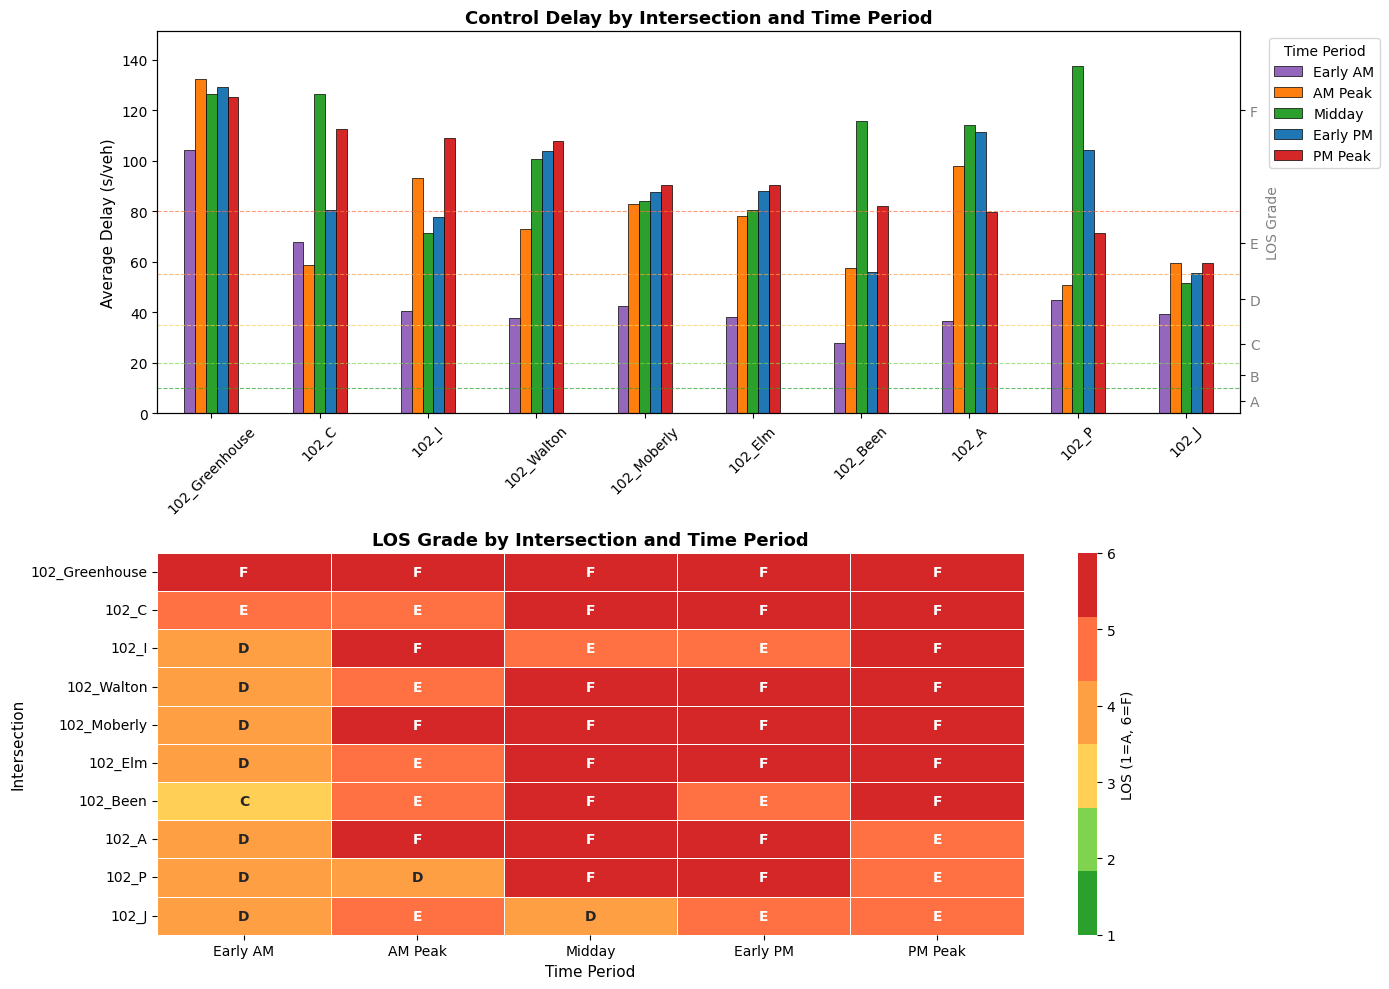


PERIOD COMPARISON SUMMARY

Period       Avg Delay    Max Delay    Total Vol      LOS F   
------------------------------------------------------------
Early AM     47.9         104.1        11,969         1       
AM Peak      78.3         132.4        24,219         4       
Midday       100.8        137.4        27,516         8       
Early PM     89.3         129.3        27,256         7       
PM Peak      92.8         125.3        29,207         7       


/var/folders/v4/6t9d5wws7d96w7cqfgjkpyw80000gn/T/ipykernel_76340/645023637.py:108: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  period_stats = df.groupby("period").agg({


In [11]:
def plot_tod_los_comparison(tod_summary_df: pd.DataFrame) -> None:
    """
    Create a grouped bar chart comparing LOS across time periods for each intersection.
    """
    # Filter out errors and prepare data
    df = tod_summary_df[tod_summary_df["LOS"] != "ERR"].copy()
    df = df.dropna(subset=["delay_s"])
    
    if df.empty:
        print("No valid data for time-of-day comparison.")
        return
    
    # Define period order
    period_order = ["Early AM", "AM Peak", "Midday", "Early PM", "PM Peak"]
    df["period"] = pd.Categorical(df["period"], categories=period_order, ordered=True)
    
    # Create figure with 2 subplots
    fig, axes = plt.subplots(2, 1, figsize=(14, 10))
    
    # Color palette for periods
    period_colors = {
        "Early AM": "#9467bd",  # Purple
        "AM Peak": "#ff7f0e",    # Orange
        "Midday": "#2ca02c",     # Green
        "Early PM": "#1f77b4",   # Blue
        "PM Peak": "#d62728",    # Red
    }
    
    # ===== Plot 1: Delay by Intersection and Period =====
    ax1 = axes[0]
    
    # Pivot for grouped bar chart
    pivot_delay = df.pivot_table(index="intersection", columns="period", values="delay_s", aggfunc="first")
    pivot_delay = pivot_delay.reindex(columns=[p for p in period_order if p in pivot_delay.columns])
    
    # Sort by PM Peak delay (usually worst)
    if "PM Peak" in pivot_delay.columns:
        pivot_delay = pivot_delay.sort_values("PM Peak", ascending=False)
    
    pivot_delay.plot(kind="bar", ax=ax1, color=[period_colors.get(c, "#999") for c in pivot_delay.columns],
                     edgecolor="black", linewidth=0.5)
    
    # Add LOS threshold lines
    ax1.axhline(10, color="#2ca02c", linestyle="--", linewidth=0.8, alpha=0.7, label="_LOS A")
    ax1.axhline(20, color="#7fd34e", linestyle="--", linewidth=0.8, alpha=0.7)
    ax1.axhline(35, color="#ffcf56", linestyle="--", linewidth=0.8, alpha=0.7)
    ax1.axhline(55, color="#ff9f43", linestyle="--", linewidth=0.8, alpha=0.7)
    ax1.axhline(80, color="#ff7043", linestyle="--", linewidth=0.8, alpha=0.7)
    
    ax1.set_ylabel("Average Delay (s/veh)", fontsize=11)
    ax1.set_xlabel("")
    ax1.set_title("Control Delay by Intersection and Time Period", fontsize=13, fontweight="bold")
    ax1.tick_params(axis="x", rotation=45)
    ax1.legend(title="Time Period", bbox_to_anchor=(1.02, 1), loc="upper left")
    ax1.set_ylim(0, min(160, df["delay_s"].max() * 1.1))
    
    # Add LOS labels on right side
    ax1_twin = ax1.twinx()
    ax1_twin.set_ylim(ax1.get_ylim())
    ax1_twin.set_yticks([5, 15, 27.5, 45, 67.5, 120])
    ax1_twin.set_yticklabels(["A", "B", "C", "D", "E", "F"], fontsize=10, color="gray")
    ax1_twin.set_ylabel("LOS Grade", fontsize=10, color="gray")
    
    # ===== Plot 2: LOS Grade Heatmap =====
    ax2 = axes[1]
    
    # Convert LOS to numeric for heatmap
    los_to_num = {"A": 1, "B": 2, "C": 3, "D": 4, "E": 5, "F": 6}
    df["LOS_num"] = df["LOS"].map(los_to_num)
    
    pivot_los = df.pivot_table(index="intersection", columns="period", values="LOS_num", aggfunc="first")
    pivot_los = pivot_los.reindex(columns=[p for p in period_order if p in pivot_los.columns])
    
    # Sort same as delay chart
    if "PM Peak" in pivot_delay.columns:
        pivot_los = pivot_los.reindex(pivot_delay.index)
    
    # Create heatmap
    cmap = sns.color_palette(["#2ca02c", "#7fd34e", "#ffcf56", "#ff9f43", "#ff7043", "#d62728"], as_cmap=True)
    
    sns.heatmap(pivot_los, annot=True, fmt=".0f", cmap=cmap, 
                vmin=1, vmax=6, center=3.5,
                linewidths=0.5, cbar_kws={"label": "LOS (1=A, 6=F)"},
                ax=ax2)
    
    # Replace numeric annotations with LOS letters
    for t in ax2.texts:
        try:
            val = int(float(t.get_text()))
            los_letter = {1: "A", 2: "B", 3: "C", 4: "D", 5: "E", 6: "F"}.get(val, "?")
            t.set_text(los_letter)
            t.set_fontweight("bold")
        except:
            pass
    
    ax2.set_xlabel("Time Period", fontsize=11)
    ax2.set_ylabel("Intersection", fontsize=11)
    ax2.set_title("LOS Grade by Intersection and Time Period", fontsize=13, fontweight="bold")
    
    plt.tight_layout()
    plt.show()
    
    # Print summary statistics
    print("\n" + "=" * 70)
    print("PERIOD COMPARISON SUMMARY")
    print("=" * 70)
    
    period_stats = df.groupby("period").agg({
        "delay_s": ["mean", "max"],
        "volume_vph": "sum",
        "LOS": lambda x: (x == "F").sum()
    }).round(1)
    period_stats.columns = ["Avg Delay", "Max Delay", "Total Volume", "LOS F Count"]
    
    print(f"\n{'Period':<12} {'Avg Delay':<12} {'Max Delay':<12} {'Total Vol':<14} {'LOS F':<8}")
    print("-" * 60)
    for period in period_order:
        if period in period_stats.index:
            row = period_stats.loc[period]
            print(f"{period:<12} {row['Avg Delay']:<12.1f} {row['Max Delay']:<12.1f} "
                  f"{row['Total Volume']:<14,.0f} {int(row['LOS F Count']):<8}")

# Generate the time-of-day comparison visualization
plot_tod_los_comparison(tod_summary_df)

## Afternoon Peak Period Analysis (12:00 PM - 6:00 PM)
The following analysis filters volume data to the afternoon peak period (12:00 PM to 6:00 PM) when traffic is typically heaviest. This provides insight into worst-case operational conditions during the busiest part of the day.

In [12]:
def parse_volume_csv_time_filtered(
    file_path: Path, 
    start_hour: int = 12, 
    end_hour: int = 18,
    aggregation: str = "peak_hour"
) -> Dict[str, Any]:
    """
    Parse volume CSV with time filtering for specific period analysis.
    
    Parameters:
    - start_hour: Start of analysis period (inclusive, 24-hour format)
    - end_hour: End of analysis period (exclusive, 24-hour format)
    - aggregation: 'peak_hour' finds peak within filtered period, 'average' uses mean hourly rate
    """
    notes: List[str] = []
    warnings: List[str] = []
    filename = file_path.name
    intersection_id = file_path.stem

    try:
        df = pd.read_csv(file_path, skiprows=2, index_col=False)
    except Exception as exc:
        raise RuntimeError(f"Failed to read {filename}: {exc}") from exc

    df = df.loc[:, ~df.columns.str.contains("^Unnamed")]
    for col in ("DATE", "TIME"):
        if col not in df.columns:
            raise RuntimeError(f"Required column {col} missing in {filename}")

    available_movements = [col for col in MOVEMENT_COLS if col in df.columns]
    if not available_movements:
        raise RuntimeError(f"No movement columns found in {filename}")

    df["TIME"] = df["TIME"].astype(str).str.extract(r"(\d{4})", expand=False)
    for col in available_movements:
        df[col] = pd.to_numeric(df[col].replace("*", np.nan), errors="coerce")
    df[available_movements] = df[available_movements].fillna(0)

    lanes_with_data = [col for col in available_movements if df[col].sum() > 0]
    if not lanes_with_data:
        raise RuntimeError(f"All movement volumes are zero in {filename}")

    # Parse datetime
    df["TIME"] = df["TIME"].fillna("0000").astype(str).str.zfill(4)
    df["DATE"] = df["DATE"].fillna("").astype(str)
    valid_mask = (df["DATE"].str.len() > 0) & (df["TIME"].str.len() == 4)
    df_valid = df[valid_mask].copy()
    
    if df_valid.empty:
        raise RuntimeError(f"No valid DATE/TIME rows found in {filename}")
    
    df_valid["DateTime"] = pd.to_datetime(
        df_valid["DATE"] + " " + df_valid["TIME"],
        format="%m/%d/%Y %H%M",
        errors="coerce",
    )
    df = df_valid.dropna(subset=["DateTime"]).sort_values("DateTime").copy()
    df["DateOnly"] = df["DateTime"].dt.date
    df["Hour"] = df["DateTime"].dt.hour

    # FILTER TO TIME PERIOD
    df_filtered = df[(df["Hour"] >= start_hour) & (df["Hour"] < end_hour)].copy()
    
    if df_filtered.empty:
        raise RuntimeError(f"No data in time period {start_hour}:00-{end_hour}:00 for {filename}")
    
    notes.append(f"Filtered to {start_hour}:00-{end_hour}:00 ({len(df_filtered)} of {len(df)} intervals)")
    
    volumes_vph: Dict[str, int] = {}
    unique_dates = df_filtered["DateOnly"].nunique()

    if aggregation == "peak_hour" and len(df_filtered) >= 4:
        # Find peak hour within the filtered time period for each day
        daily_peak_volumes: Dict[str, List[int]] = {col: [] for col in lanes_with_data}
        
        for date_val, day_df in df_filtered.groupby("DateOnly"):
            if len(day_df) < 4:
                continue
            
            day_df = day_df.sort_values("DateTime").reset_index(drop=True)
            day_df["TotalVol"] = day_df[lanes_with_data].sum(axis=1)
            
            # Find peak hour within this day's filtered period
            best_sum = 0
            best_start_idx = 0
            for i in range(len(day_df) - 3):
                window_sum = day_df["TotalVol"].iloc[i:i+4].sum()
                if window_sum > best_sum:
                    best_sum = window_sum
                    best_start_idx = i
            
            peak_df = day_df.iloc[best_start_idx:best_start_idx + 4]
            
            for col in lanes_with_data:
                daily_peak_volumes[col].append(int(peak_df[col].sum()))
        
        if daily_peak_volumes[lanes_with_data[0]]:
            num_days = len(daily_peak_volumes[lanes_with_data[0]])
            for col in lanes_with_data:
                avg_peak_vol = sum(daily_peak_volumes[col]) / len(daily_peak_volumes[col])
                volumes_vph[col] = int(round(avg_peak_vol))
            notes.append(f"Peak hour volumes averaged across {num_days} days")
        else:
            # Fallback to average
            total_hours = len(df_filtered) * 0.25 or 1.0
            for col in lanes_with_data:
                volumes_vph[col] = int(df_filtered[col].sum() / total_hours)
    else:
        # Average hourly rate
        total_hours = len(df_filtered) * 0.25 or 1.0
        for col in lanes_with_data:
            volumes_vph[col] = int(df_filtered[col].sum() / total_hours)
        notes.append(f"Average hourly volumes over {total_hours:.1f} hours")

    return {
        "intersection_id": intersection_id,
        "volumes_vph": volumes_vph,
        "total_intervals": len(df_filtered),
        "lanes_with_data": lanes_with_data,
        "time_period": f"{start_hour}:00-{end_hour}:00",
        "notes": notes,
        "warnings": warnings,
    }


def compute_los_for_time_period(
    phase_dir: Path,
    volume_dir: Path,
    start_hour: int = 12,
    end_hour: int = 18,
    saturation_flow: int = DEFAULT_SATURATION_FLOW,
    plan_number: int = 25,
) -> Dict[str, Any]:
    """Compute LOS for a specific time period across all intersections."""
    phase_files = {path.stem: path for path in phase_dir.glob("*.csv")}
    volume_files = {path.stem: path for path in volume_dir.glob("*.csv")}
    all_ids = sorted(set(phase_files) & set(volume_files))
    
    results: Dict[str, Any] = {}
    
    for intersection_id in all_ids:
        phase_path = phase_files[intersection_id]
        volume_path = volume_files[intersection_id]
        
        try:
            timing = parse_phase_timing_csv(phase_path, plan_number=plan_number)
            volume = parse_volume_csv_time_filtered(
                volume_path, 
                start_hour=start_hour, 
                end_hour=end_hour,
                aggregation="peak_hour"
            )
            
            per_lane_results: List[Dict[str, Any]] = []
            cycle_length = timing["cycle_length_s"]
            movement_greens = timing.get("movement_green_times", {})
            
            for movement, volume_vph in volume["volumes_vph"].items():
                if volume_vph <= 0:
                    continue
                
                green_time, match_type = get_green_time_for_movement(
                    movement, movement_greens, cycle_length
                )
                
                delay, degree_of_saturation, g_over_c = compute_control_delay(
                    volume_vph=volume_vph,
                    saturation_flow=saturation_flow,
                    green_time_s=green_time,
                    cycle_length_s=cycle_length,
                )
                
                per_lane_results.append({
                    "movement": movement,
                    "volume_vph": volume_vph,
                    "g_s": round(green_time, 1),
                    "g_over_C": round(g_over_c, 3),
                    "degree_of_saturation": round(degree_of_saturation, 3),
                    "delay_s_per_veh": round(delay, 1),
                    "LOS": determine_los(delay),
                })
            
            intersection_summary = compute_intersection_los(per_lane_results)
            
            results[intersection_id] = {
                "intersection_id": intersection_id,
                "cycle_length_s": round(cycle_length, 1),
                "per_lane": per_lane_results,
                "intersection": intersection_summary,
                "time_period": volume.get("time_period"),
                "notes": timing.get("notes", []) + volume.get("notes", []),
            }
            
        except Exception as exc:
            results[intersection_id] = {
                "intersection_id": intersection_id,
                "error": str(exc),
            }
    
    return {"intersections": results, "time_period": f"{start_hour}:00-{end_hour}:00"}


# Compute LOS for 1 PM - 7 PM period
afternoon_results = compute_los_for_time_period(
    PHASE_DIR, VOLUME_DIR, 
    start_hour=13, end_hour=19
)

# Convert to DataFrame for comparison
afternoon_records = []
for int_id, payload in afternoon_results["intersections"].items():
    if "error" in payload:
        afternoon_records.append({"intersection_id": int_id, "error": payload["error"]})
    else:
        summary = payload["intersection"]
        afternoon_records.append({
            "intersection_id": int_id,
            "average_delay_s": summary["average_delay_s_per_veh"],
            "LOS": summary["LOS"],
            "total_volume_vph": summary["total_volume_vph"],
            "cycle_length_s": payload["cycle_length_s"],
        })

afternoon_df = pd.DataFrame(afternoon_records)

print("=" * 70)
print("LOS ANALYSIS: Afternoon Peak Period (1:00 PM - 7:00 PM)")
print("=" * 70)
print(f"\nThis analysis uses peak-hour volumes within the 1-7 PM window,")
print(f"averaged across all days in the dataset.\n")

print(f"{'Intersection':<18} {'Delay (s)':<12} {'LOS':<6} {'Volume (vph)':<14} {'Cycle (s)'}")
print("-" * 70)
for _, row in afternoon_df.sort_values("intersection_id").iterrows():
    if "error" in row and pd.notna(row.get("error")):
        print(f"{row['intersection_id']:<18} ERROR: {row['error'][:40]}")
    else:
        print(f"{row['intersection_id']:<18} {row['average_delay_s']:<12.1f} {row['LOS']:<6} "
              f"{row['total_volume_vph']:<14,} {row['cycle_length_s']:.0f}")

print("\n" + "-" * 70)
print("LOS Distribution (1 PM - 7 PM):")
print(afternoon_df["LOS"].value_counts().sort_index().to_string())

/var/folders/v4/6t9d5wws7d96w7cqfgjkpyw80000gn/T/ipykernel_76340/2323910921.py:36: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df[col] = pd.to_numeric(df[col].replace("*", np.nan), errors="coerce")
/var/folders/v4/6t9d5wws7d96w7cqfgjkpyw80000gn/T/ipykernel_76340/2323910921.py:36: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df[col] = pd.to_numeric(df[col].replace("*", np.nan), errors="coerce")
/var/folders/v4/6t9d5wws7d96w7cqfgjkpyw80000gn/T/ipykernel_76340/2323910921.py:36: FutureWarning: Downcasting behavior in `replace` is d

LOS ANALYSIS: Afternoon Peak Period (1:00 PM - 7:00 PM)

This analysis uses peak-hour volumes within the 1-7 PM window,
averaged across all days in the dataset.

Intersection       Delay (s)    LOS    Volume (vph)   Cycle (s)
----------------------------------------------------------------------
102_A              76.2         E      3,003          161
102_Been           73.6         E      3,083          165
102_C              124.3        F      2,362          150
102_Elm            89.5         F      2,680          150
102_Greenhouse     127.8        F      3,186          132
102_I              83.2         F      3,744          160
102_J              52.4         D      3,216          163
102_Moberly        69.1         E      2,291          161
102_P              129.9        F      2,205          150
102_Walton         82.1         F      4,020          161

----------------------------------------------------------------------
LOS Distribution (1 PM - 7 PM):
LOS
D    1
E    3
F

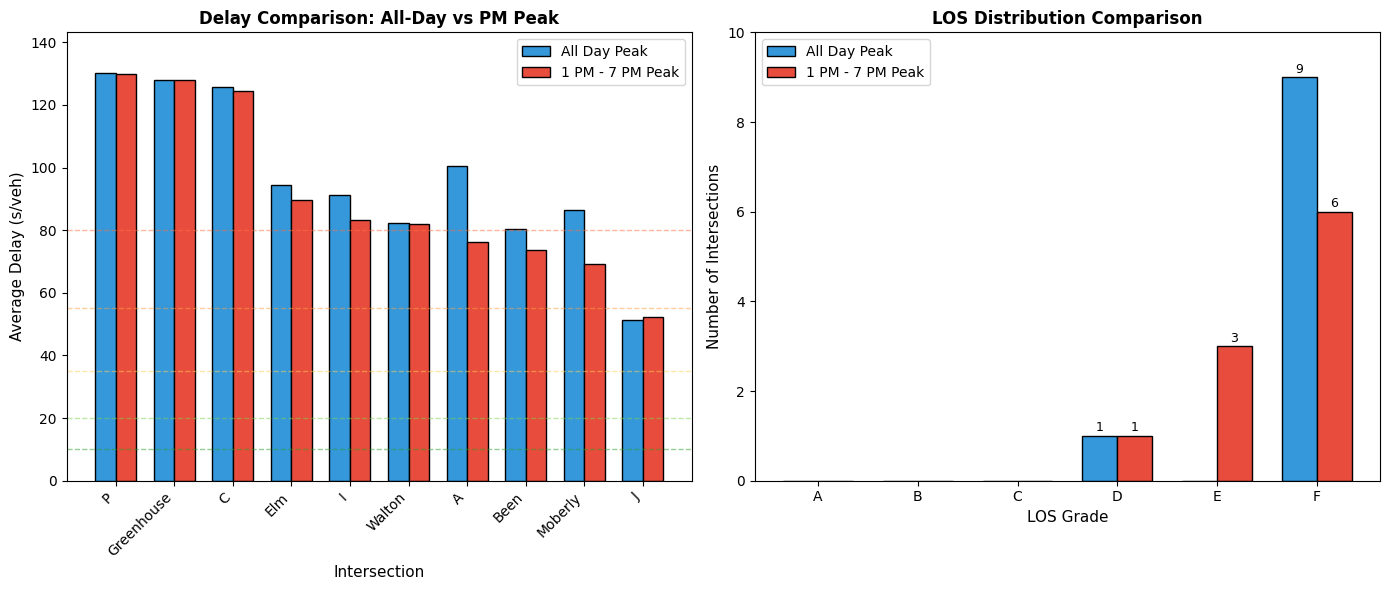


LOS Changes: All-Day vs Afternoon Peak (12 PM - 6 PM)

Intersection       All-Day    Afternoon  Change
-------------------------------------------------------
102_A              F          E          ↓ Better
102_Been           F          E          ↓ Better
102_Moberly        F          E          ↓ Better


In [13]:
def plot_los_comparison(all_day_df: pd.DataFrame, afternoon_df: pd.DataFrame) -> None:
    """
    Compare LOS grades between all-day analysis and afternoon peak period.
    """
    # Merge the two dataframes
    comparison = all_day_df[["intersection_id", "average_delay_s", "LOS"]].merge(
        afternoon_df[["intersection_id", "average_delay_s", "LOS"]],
        on="intersection_id",
        suffixes=("_allday", "_afternoon")
    )
    
    comparison = comparison.sort_values("average_delay_s_afternoon", ascending=False)
    
    fig, axes = plt.subplots(1, 2, figsize=(14, 6))
    
    # Left plot: Bar chart comparing delays
    ax1 = axes[0]
    x = np.arange(len(comparison))
    width = 0.35
    
    bars1 = ax1.bar(x - width/2, comparison["average_delay_s_allday"], width, 
                    label="All Day Peak", color="#3498db", edgecolor="black")
    bars2 = ax1.bar(x + width/2, comparison["average_delay_s_afternoon"], width,
                    label="1 PM - 7 PM Peak", color="#e74c3c", edgecolor="black")
    
    # Add LOS threshold lines
    ax1.axhline(10, color="#2ca02c", linestyle="--", alpha=0.5, linewidth=1)
    ax1.axhline(20, color="#7fd34e", linestyle="--", alpha=0.5, linewidth=1)
    ax1.axhline(35, color="#ffcf56", linestyle="--", alpha=0.5, linewidth=1)
    ax1.axhline(55, color="#ff9f43", linestyle="--", alpha=0.5, linewidth=1)
    ax1.axhline(80, color="#ff7043", linestyle="--", alpha=0.5, linewidth=1)
    
    ax1.set_ylabel("Average Delay (s/veh)", fontsize=11)
    ax1.set_xlabel("Intersection", fontsize=11)
    ax1.set_title("Delay Comparison: All-Day vs PM Peak", fontsize=12, fontweight="bold")
    ax1.set_xticks(x)
    ax1.set_xticklabels([i.replace("102_", "") for i in comparison["intersection_id"]], 
                        rotation=45, ha="right")
    ax1.legend(loc="upper right")
    ax1.set_ylim(0, max(comparison[["average_delay_s_allday", "average_delay_s_afternoon"]].max()) * 1.1)
    
    # Right plot: LOS grade distribution comparison
    ax2 = axes[1]
    
    los_order = ["A", "B", "C", "D", "E", "F"]
    los_colors = {"A": "#2ca02c", "B": "#7fd34e", "C": "#ffcf56", 
                  "D": "#ff9f43", "E": "#ff7043", "F": "#d62728"}
    
    # Count LOS grades for each period
    allday_counts = all_day_df["LOS"].value_counts().reindex(los_order, fill_value=0)
    afternoon_counts = afternoon_df["LOS"].value_counts().reindex(los_order, fill_value=0)
    
    x2 = np.arange(len(los_order))
    bars3 = ax2.bar(x2 - width/2, allday_counts.values, width, 
                    label="All Day Peak", color="#3498db", edgecolor="black")
    bars4 = ax2.bar(x2 + width/2, afternoon_counts.values, width,
                    label="1 PM - 7 PM Peak", color="#e74c3c", edgecolor="black")
    
    ax2.set_ylabel("Number of Intersections", fontsize=11)
    ax2.set_xlabel("LOS Grade", fontsize=11)
    ax2.set_title("LOS Distribution Comparison", fontsize=12, fontweight="bold")
    ax2.set_xticks(x2)
    ax2.set_xticklabels(los_order)
    ax2.legend(loc="upper left")
    ax2.set_ylim(0, max(max(allday_counts), max(afternoon_counts)) + 1)
    
    # Add count labels on bars
    for bar in bars3:
        if bar.get_height() > 0:
            ax2.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.1,
                    f"{int(bar.get_height())}", ha="center", fontsize=9)
    for bar in bars4:
        if bar.get_height() > 0:
            ax2.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.1,
                    f"{int(bar.get_height())}", ha="center", fontsize=9)
    
    plt.tight_layout()
    plt.show()
    
    # Print summary of changes
    print("\n" + "=" * 60)
    print("LOS Changes: All-Day vs Afternoon Peak (12 PM - 6 PM)")
    print("=" * 60)
    
    changes = []
    for _, row in comparison.iterrows():
        if row["LOS_allday"] != row["LOS_afternoon"]:
            direction = "↑ Worse" if los_order.index(row["LOS_afternoon"]) > los_order.index(row["LOS_allday"]) else "↓ Better"
            changes.append({
                "intersection": row["intersection_id"],
                "allday": row["LOS_allday"],
                "afternoon": row["LOS_afternoon"],
                "direction": direction
            })
    
    if changes:
        print(f"\n{'Intersection':<18} {'All-Day':<10} {'Afternoon':<10} {'Change'}")
        print("-" * 55)
        for c in changes:
            print(f"{c['intersection']:<18} {c['allday']:<10} {c['afternoon']:<10} {c['direction']}")
    else:
        print("\nNo LOS grade changes between periods.")


# Plot the comparison (using los_df from earlier all-day analysis)
plot_los_comparison(los_df.dropna(subset=["LOS"]), afternoon_df.dropna(subset=["LOS"]))

## Detailed Movement-Level Analysis
The overall LOS grade hides significant variation between movements. The following visualizations break down performance by individual movements to identify **which specific turning movements are causing the most delay**. This helps engineers target improvements (e.g., adding turn lanes, adjusting phase splits, or retiming).

In [14]:
def create_movement_dataframe(results: Dict[str, Any]) -> pd.DataFrame:
    """Extract all per-movement data into a flat DataFrame for visualization."""
    records = []
    for int_id, payload in results.get("intersections", {}).items():
        if "error" in payload:
            continue
        for lane in payload.get("per_lane", []):
            records.append({
                "intersection": int_id,
                "movement": lane.get("movement", "?"),
                "direction": lane.get("movement", "??")[:2],
                "turn_type": lane.get("movement", "???")[2] if len(lane.get("movement", "")) > 2 else "?",
                "volume_vph": lane.get("volume_vph", 0),
                "green_s": lane.get("g_s", 0),
                "g_over_C": lane.get("g_over_C", 0),
                "v_over_c": lane.get("degree_of_saturation", 0),
                "delay_s": lane.get("delay_s_per_veh", 0),
                "LOS": lane.get("LOS", "F"),
            })
    return pd.DataFrame(records)

# Create the movement-level dataframe
movement_df = create_movement_dataframe(los_results)
print(f"Total movements analyzed: {len(movement_df)}")
print(f"\nMovement counts by LOS grade:")
print(movement_df["LOS"].value_counts().sort_index())
print(f"\nWorst performing movements (highest delay):")
print(movement_df.nlargest(10, "delay_s")[["intersection", "movement", "volume_vph", "v_over_c", "delay_s", "LOS"]].to_string(index=False))

Total movements analyzed: 106

Movement counts by LOS grade:
LOS
B     5
C    24
D    31
E    27
F    19
Name: count, dtype: int64

Worst performing movements (highest delay):
  intersection movement  volume_vph  v_over_c  delay_s LOS
         102_A      EBT        1109     1.220    150.0   F
         102_C      EBT        1077     1.604    150.0   F
         102_C      WBT         876     1.305    150.0   F
       102_Elm      WBT        1068     1.877    150.0   F
102_Greenhouse      NBT         277     1.284    150.0   F
102_Greenhouse      NBR         317     1.470    150.0   F
102_Greenhouse      EBT        1054     2.094    150.0   F
102_Greenhouse      WBT        1006     1.999    150.0   F
   102_Moberly      WBT         886     1.317    150.0   F
         102_P      EBT         990     1.400    150.0   F


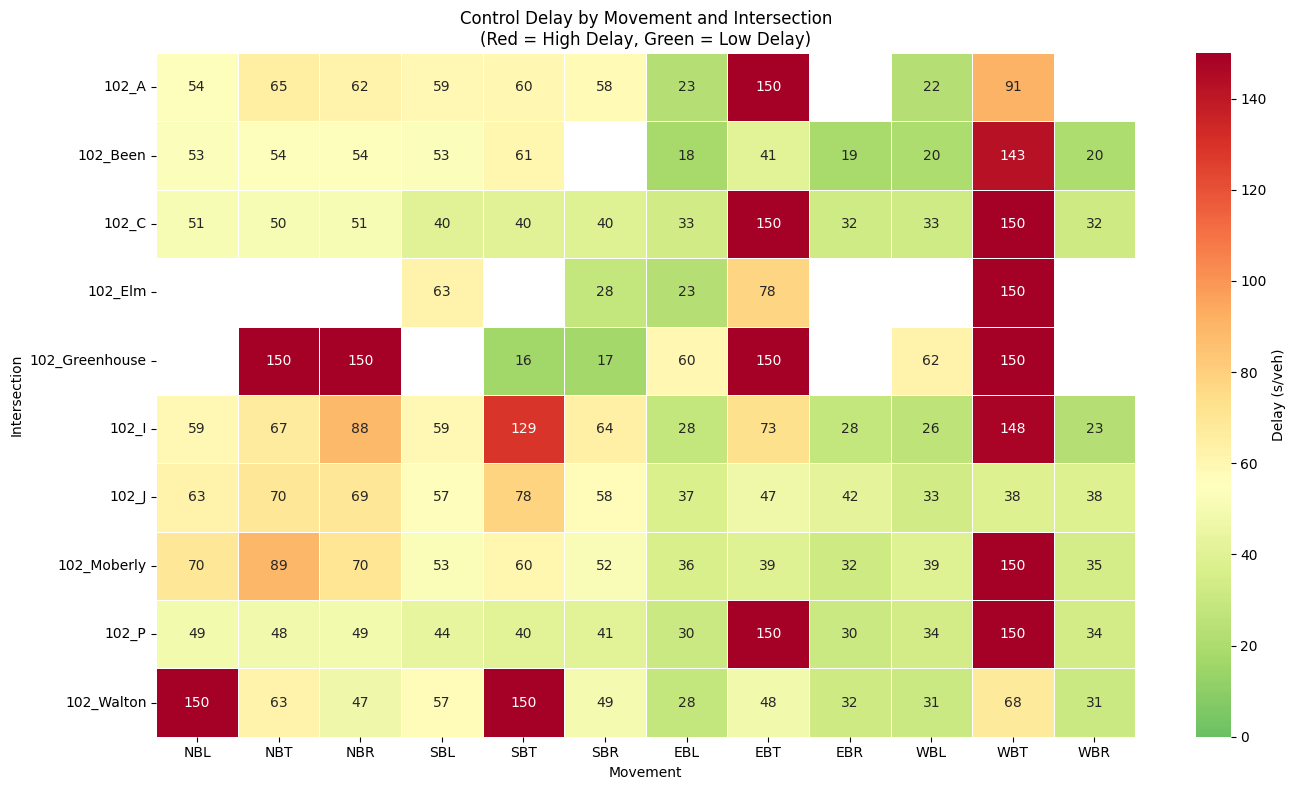

In [15]:
def plot_movement_heatmap(movement_df: pd.DataFrame) -> None:
    """
    Create a heatmap showing delay by movement for each intersection.
    This quickly identifies which specific movements are failing.
    """
    # Pivot to create intersection x movement matrix
    pivot_df = movement_df.pivot_table(
        index="intersection", 
        columns="movement", 
        values="delay_s",
        aggfunc="first"
    )
    
    # Reorder columns by direction groups
    movement_order = ["NBL", "NBT", "NBR", "SBL", "SBT", "SBR", 
                      "EBL", "EBT", "EBR", "WBL", "WBT", "WBR"]
    pivot_df = pivot_df.reindex(columns=[c for c in movement_order if c in pivot_df.columns])
    
    # Create heatmap
    fig, ax = plt.subplots(figsize=(14, 8))
    
    # Custom colormap: green (good) -> yellow -> orange -> red (bad)
    cmap = sns.color_palette("RdYlGn_r", as_cmap=True)
    
    sns.heatmap(
        pivot_df,
        annot=True,
        fmt=".0f",
        cmap=cmap,
        center=55,  # Center at LOS E threshold
        vmin=0,
        vmax=150,
        linewidths=0.5,
        cbar_kws={"label": "Delay (s/veh)"},
        ax=ax
    )
    
    ax.set_title("Control Delay by Movement and Intersection\n(Red = High Delay, Green = Low Delay)", fontsize=12)
    ax.set_xlabel("Movement")
    ax.set_ylabel("Intersection")
    
    # Add LOS threshold annotations on colorbar
    plt.tight_layout()
    plt.show()

plot_movement_heatmap(movement_df)

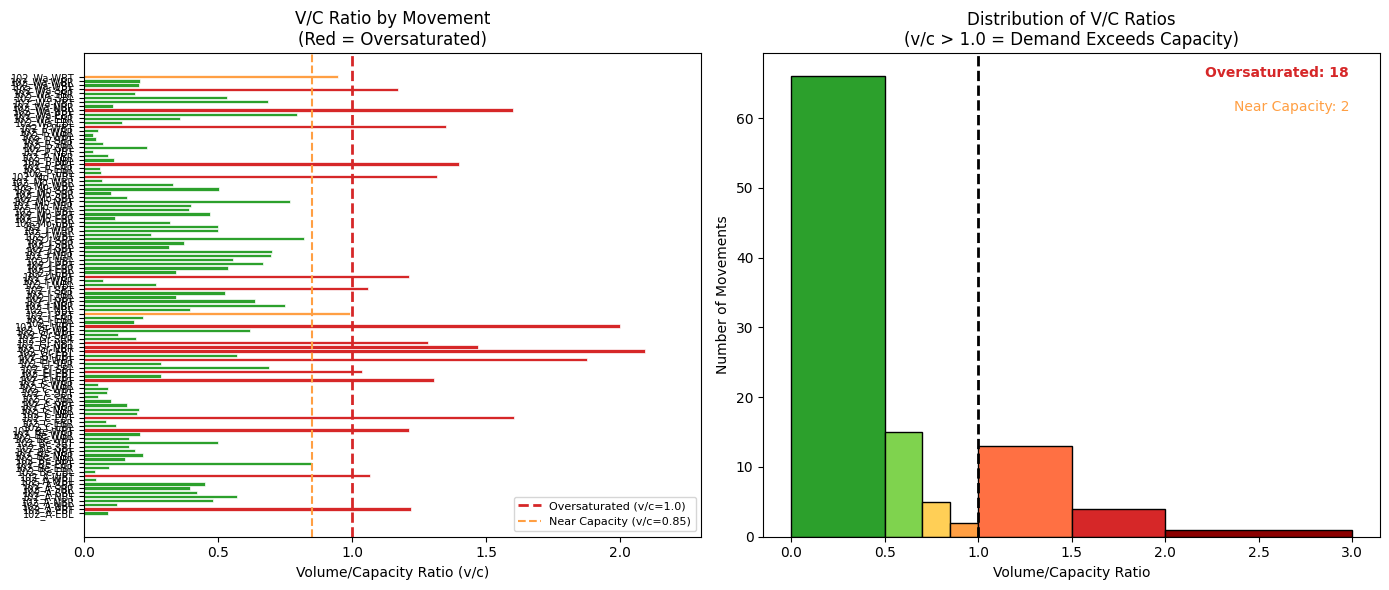

In [16]:
def plot_vc_ratio_analysis(movement_df: pd.DataFrame) -> None:
    """
    Plot volume-to-capacity (v/c) ratio analysis.
    v/c > 1.0 means demand exceeds capacity - a critical problem.
    """
    fig, axes = plt.subplots(1, 2, figsize=(14, 6))
    
    # Left plot: v/c ratio by intersection and movement
    ax1 = axes[0]
    
    # Color by oversaturation status
    movement_df_sorted = movement_df.sort_values(["intersection", "movement"])
    colors = ["#d62728" if vc > 1.0 else "#ff9f43" if vc > 0.85 else "#2ca02c" 
              for vc in movement_df_sorted["v_over_c"]]
    
    bars = ax1.barh(
        range(len(movement_df_sorted)),
        movement_df_sorted["v_over_c"],
        color=colors,
        edgecolor="white",
        linewidth=0.5
    )
    
    # Add threshold lines
    ax1.axvline(1.0, color="#d62728", linestyle="--", linewidth=2, label="Oversaturated (v/c=1.0)")
    ax1.axvline(0.85, color="#ff9f43", linestyle="--", linewidth=1.5, label="Near Capacity (v/c=0.85)")
    
    # Labels
    labels = [f"{row['intersection'][:6]}-{row['movement']}" 
              for _, row in movement_df_sorted.iterrows()]
    ax1.set_yticks(range(len(labels)))
    ax1.set_yticklabels(labels, fontsize=7)
    ax1.set_xlabel("Volume/Capacity Ratio (v/c)")
    ax1.set_title("V/C Ratio by Movement\n(Red = Oversaturated)")
    ax1.legend(loc="lower right", fontsize=8)
    ax1.set_xlim(0, max(2.0, movement_df_sorted["v_over_c"].max() * 1.1))
    
    # Right plot: Distribution of v/c ratios
    ax2 = axes[1]
    
    # Histogram with color coding
    bins = [0, 0.5, 0.7, 0.85, 1.0, 1.5, 2.0, 3.0]
    colors_hist = ["#2ca02c", "#7fd34e", "#ffcf56", "#ff9f43", "#ff7043", "#d62728", "#8b0000"]
    
    n, bins_out, patches = ax2.hist(movement_df["v_over_c"], bins=bins, edgecolor="black")
    
    for patch, color in zip(patches, colors_hist):
        patch.set_facecolor(color)
    
    ax2.axvline(1.0, color="black", linestyle="--", linewidth=2)
    ax2.set_xlabel("Volume/Capacity Ratio")
    ax2.set_ylabel("Number of Movements")
    ax2.set_title("Distribution of V/C Ratios\n(v/c > 1.0 = Demand Exceeds Capacity)")
    
    # Add annotations
    oversaturated = (movement_df["v_over_c"] > 1.0).sum()
    near_capacity = ((movement_df["v_over_c"] > 0.85) & (movement_df["v_over_c"] <= 1.0)).sum()
    ax2.annotate(f"Oversaturated: {oversaturated}", xy=(0.95, 0.95), xycoords="axes fraction",
                 ha="right", fontsize=10, color="#d62728", fontweight="bold")
    ax2.annotate(f"Near Capacity: {near_capacity}", xy=(0.95, 0.88), xycoords="axes fraction",
                 ha="right", fontsize=10, color="#ff9f43")
    
    plt.tight_layout()
    plt.show()

plot_vc_ratio_analysis(movement_df)

Detailed breakdown for selected intersections:



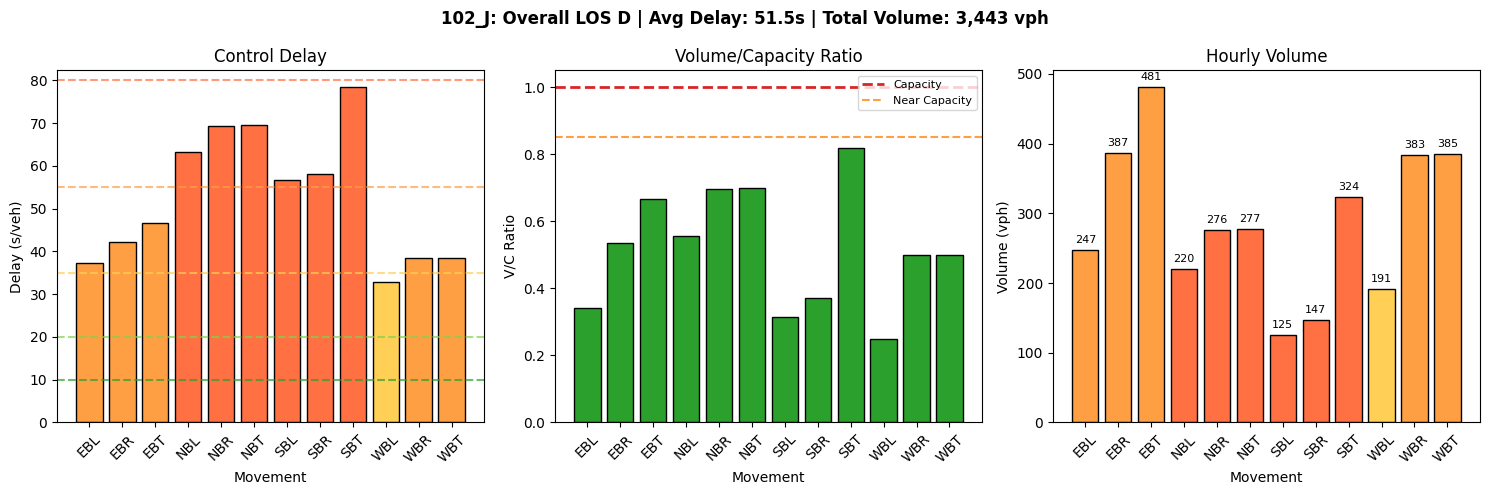

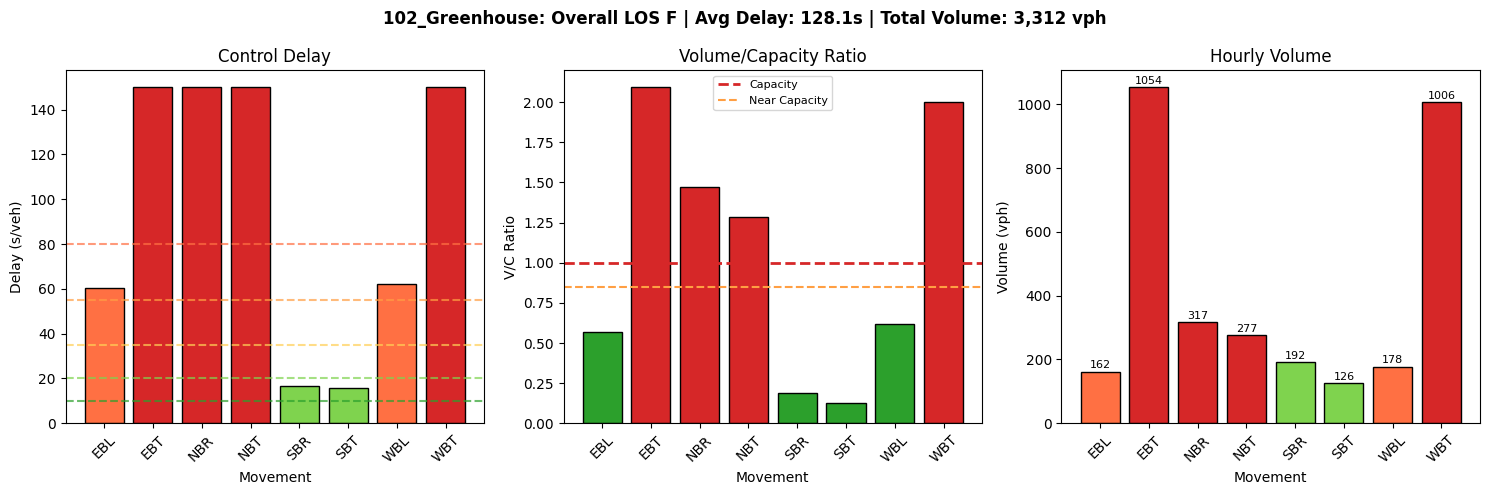

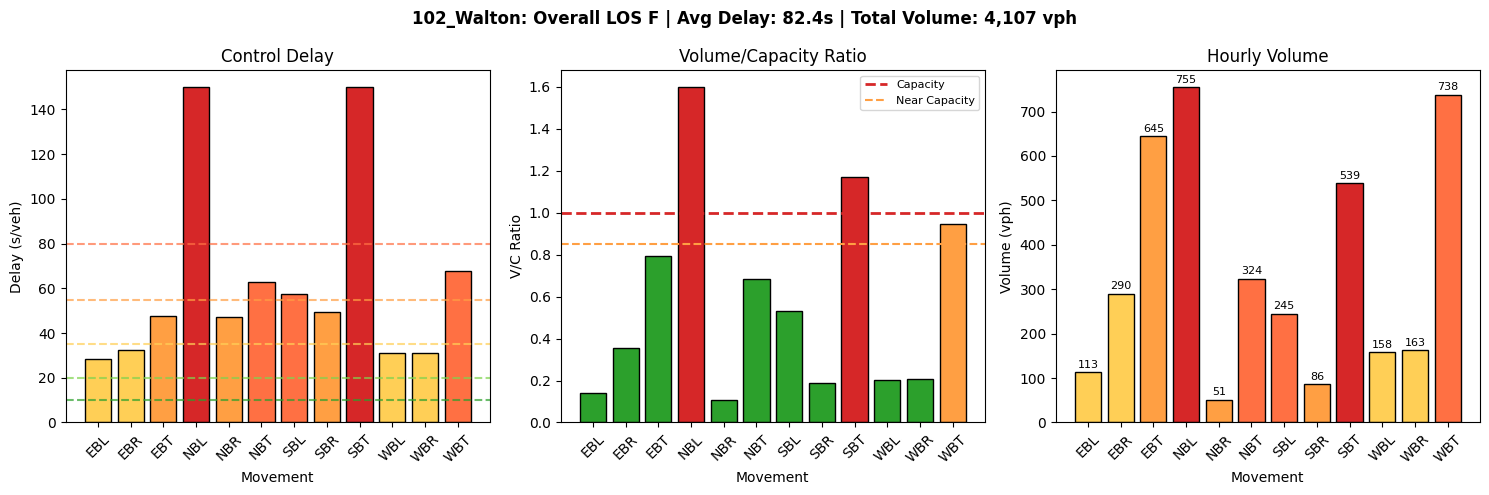

In [17]:
def plot_intersection_breakdown(results: Dict[str, Any], intersection_id: str) -> None:
    """
    Create a detailed breakdown for a single intersection showing
    delay and v/c ratio for each movement.
    """
    payload = results.get("intersections", {}).get(intersection_id)
    if not payload or "error" in payload:
        print(f"No data for intersection {intersection_id}")
        return
    
    per_lane = payload.get("per_lane", [])
    if not per_lane:
        print(f"No movement data for {intersection_id}")
        return
    
    # Sort by movement
    df = pd.DataFrame(per_lane).sort_values("movement")
    
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))
    
    # Color palette based on LOS
    los_colors = {
        "A": "#2ca02c", "B": "#7fd34e", "C": "#ffcf56",
        "D": "#ff9f43", "E": "#ff7043", "F": "#d62728"
    }
    colors = [los_colors.get(los, "#999999") for los in df["LOS"]]
    
    # Plot 1: Delay by movement
    ax1 = axes[0]
    bars1 = ax1.bar(df["movement"], df["delay_s_per_veh"], color=colors, edgecolor="black")
    ax1.axhline(10, color="#2ca02c", linestyle="--", alpha=0.7, label="LOS A")
    ax1.axhline(20, color="#7fd34e", linestyle="--", alpha=0.7, label="LOS B")
    ax1.axhline(35, color="#ffcf56", linestyle="--", alpha=0.7, label="LOS C")
    ax1.axhline(55, color="#ff9f43", linestyle="--", alpha=0.7, label="LOS D")
    ax1.axhline(80, color="#ff7043", linestyle="--", alpha=0.7, label="LOS E")
    ax1.set_ylabel("Delay (s/veh)")
    ax1.set_xlabel("Movement")
    ax1.set_title("Control Delay")
    ax1.tick_params(axis="x", rotation=45)
    
    # Plot 2: V/C ratio
    ax2 = axes[1]
    vc_colors = ["#d62728" if vc > 1.0 else "#ff9f43" if vc > 0.85 else "#2ca02c" 
                 for vc in df["degree_of_saturation"]]
    bars2 = ax2.bar(df["movement"], df["degree_of_saturation"], color=vc_colors, edgecolor="black")
    ax2.axhline(1.0, color="#d62728", linestyle="--", linewidth=2, label="Capacity")
    ax2.axhline(0.85, color="#ff9f43", linestyle="--", label="Near Capacity")
    ax2.set_ylabel("V/C Ratio")
    ax2.set_xlabel("Movement")
    ax2.set_title("Volume/Capacity Ratio")
    ax2.tick_params(axis="x", rotation=45)
    ax2.legend(fontsize=8)
    
    # Plot 3: Volume distribution (pie/bar)
    ax3 = axes[2]
    ax3.bar(df["movement"], df["volume_vph"], color=colors, edgecolor="black")
    ax3.set_ylabel("Volume (vph)")
    ax3.set_xlabel("Movement")
    ax3.set_title("Hourly Volume")
    ax3.tick_params(axis="x", rotation=45)
    
    # Add values on bars
    for bar, vol in zip(ax3.patches, df["volume_vph"]):
        ax3.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 10, 
                 f"{vol}", ha="center", fontsize=8)
    
    summary = payload["intersection"]
    fig.suptitle(f"{intersection_id}: Overall LOS {summary['LOS']} | "
                 f"Avg Delay: {summary['average_delay_s_per_veh']:.1f}s | "
                 f"Total Volume: {summary['total_volume_vph']:,} vph",
                 fontsize=12, fontweight="bold")
    
    plt.tight_layout()
    plt.show()

# Show breakdown for a few key intersections
print("Detailed breakdown for selected intersections:\n")
for int_id in ["102_J", "102_Greenhouse", "102_Walton"]:  # One D, two F's to compare
    plot_intersection_breakdown(los_results, int_id)

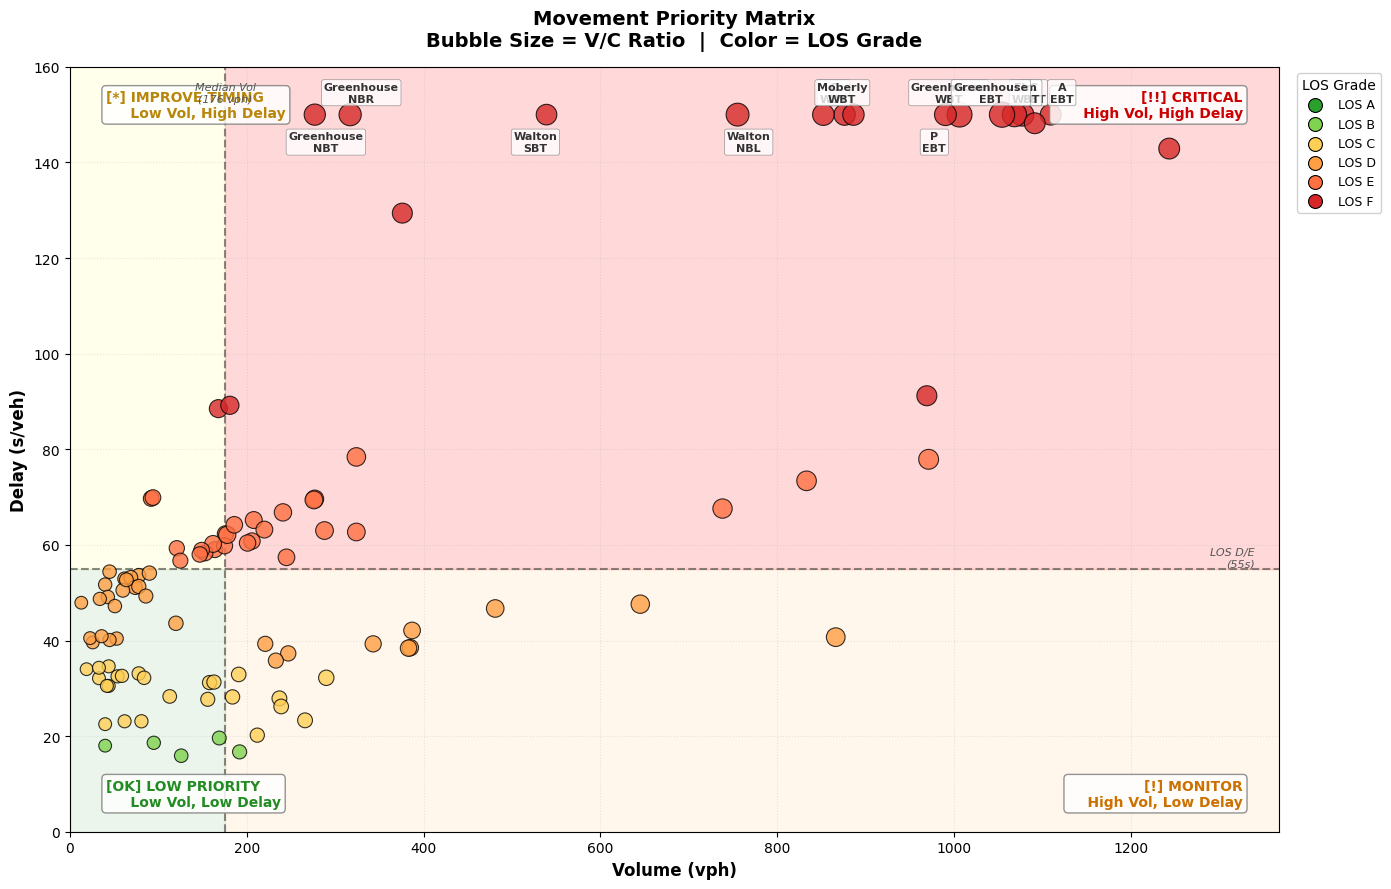


  CRITICAL MOVEMENTS - High Volume + High Delay (Priority Action Needed)

  Intersection     Movement   Volume       Delay        V/C        LOS
  ----------------------------------------------------------------------
  102_Greenhouse   NBT             277 vph     150.0 s     1.28     F
  102_Moberly      WBT             886 vph     150.0 s     1.32     F
  102_P            WBT             852 vph     150.0 s     1.35     F
  102_Greenhouse   EBT           1,054 vph     150.0 s     2.09     F
  102_Greenhouse   NBR             317 vph     150.0 s     1.47     F
  102_P            EBT             990 vph     150.0 s     1.40     F
  102_Greenhouse   WBT           1,006 vph     150.0 s     2.00     F
  102_Elm          WBT           1,068 vph     150.0 s     1.88     F
  102_Walton       NBL             755 vph     150.0 s     1.60     F
  102_C            WBT             876 vph     150.0 s     1.30     F
  102_C            EBT           1,077 vph     150.0 s     1.60     F
  102_Walto

In [18]:
def plot_priority_matrix(movement_df: pd.DataFrame) -> None:
    """
    Create a priority matrix showing which movements need the most attention.
    Plots delay vs volume - high volume + high delay = highest priority.
    """
    fig, ax = plt.subplots(figsize=(14, 9))
    
    # LOS color palette
    los_colors = {
        "A": "#2ca02c", "B": "#7fd34e", "C": "#ffcf56",
        "D": "#ff9f43", "E": "#ff7043", "F": "#d62728"
    }
    colors = [los_colors.get(los, "#999999") for los in movement_df["LOS"]]
    
    # Size by v/c ratio (bigger = more oversaturated)
    sizes = 80 + movement_df["v_over_c"] * 120
    
    # Calculate quadrant boundaries
    vol_median = movement_df["volume_vph"].median()
    delay_threshold = 55  # LOS D/E threshold
    
    # Calculate plot limits
    x_min, x_max = 0, movement_df["volume_vph"].max() * 1.1
    y_min, y_max = 0, min(160, movement_df["delay_s"].max() * 1.1)
    
    # Add shaded quadrant backgrounds for clarity
    # Bottom = Low Delay, Top = High Delay; Left = Low Volume, Right = High Volume
    ax.axhspan(y_min, delay_threshold, xmin=0, xmax=vol_median/x_max, 
               alpha=0.08, color="green", zorder=0)  # Bottom-left: Low priority (low vol, low delay)
    ax.axhspan(y_min, delay_threshold, xmin=vol_median/x_max, xmax=1, 
               alpha=0.08, color="orange", zorder=0)  # Bottom-right: Monitor (high vol, low delay)
    ax.axhspan(delay_threshold, y_max, xmin=0, xmax=vol_median/x_max, 
               alpha=0.08, color="yellow", zorder=0)  # Top-left: Improve timing (low vol, high delay)
    ax.axhspan(delay_threshold, y_max, xmin=vol_median/x_max, xmax=1, 
               alpha=0.15, color="red", zorder=0)  # Top-right: CRITICAL (high vol, high delay)
    
    # Plot scatter points
    scatter = ax.scatter(
        movement_df["volume_vph"],
        movement_df["delay_s"],
        c=colors,
        s=sizes,
        alpha=0.8,
        edgecolors="black",
        linewidth=0.8,
        zorder=3
    )
    
    # Add quadrant divider lines
    ax.axhline(delay_threshold, color="#555555", linestyle="--", linewidth=1.5, alpha=0.7, zorder=2)
    ax.axvline(vol_median, color="#555555", linestyle="--", linewidth=1.5, alpha=0.7, zorder=2)
    
    # Quadrant labels with better styling (using ASCII-safe symbols)
    # Top = High Delay (y-axis increases upward), Bottom = Low Delay
    # Left = Low Volume, Right = High Volume
    label_style = dict(fontsize=10, fontweight="bold", 
                       bbox=dict(boxstyle="round,pad=0.3", facecolor="white", alpha=0.85, edgecolor="gray"))
    
    ax.text(0.03, 0.03, "[OK] LOW PRIORITY\n     Low Vol, Low Delay", 
            transform=ax.transAxes, va="bottom", color="#228B22", **label_style)
    ax.text(0.97, 0.03, "[!] MONITOR\n    High Vol, Low Delay", 
            transform=ax.transAxes, va="bottom", ha="right", color="#CC7000", **label_style)
    ax.text(0.03, 0.97, "[*] IMPROVE TIMING\n     Low Vol, High Delay", 
            transform=ax.transAxes, va="top", color="#B8860B", **label_style)
    ax.text(0.97, 0.97, "[!!] CRITICAL\n      High Vol, High Delay", 
            transform=ax.transAxes, va="top", ha="right", color="#CC0000", **label_style)
    
    # Identify critical movements (high volume + high delay)
    critical = movement_df[(movement_df["delay_s"] > delay_threshold) & 
                           (movement_df["volume_vph"] > vol_median)].copy()
    
    # Annotate critical points with labels
    if len(critical) > 0:
        critical = critical.sort_values("delay_s", ascending=False)
        
        # Track positions to avoid overlap
        annotated_positions = []
        
        for i, (_, row) in enumerate(critical.head(12).iterrows()):
            # Shorten intersection name for cleaner labels
            int_name = row['intersection'].replace('102_', '')
            label = f"{int_name}\n{row['movement']}"
            
            # Basic offset to reduce overlap
            x_offset = 8 if i % 2 == 0 else -8
            y_offset = 8 if i % 3 != 0 else -12
            
            ax.annotate(
                label,
                (row["volume_vph"], row["delay_s"]),
                fontsize=8,
                fontweight="bold",
                ha="center",
                va="bottom" if y_offset > 0 else "top",
                color="#333333",
                xytext=(x_offset, y_offset),
                textcoords="offset points",
                bbox=dict(boxstyle="round,pad=0.2", facecolor="white", alpha=0.8, edgecolor="gray", linewidth=0.5),
                zorder=5
            )
    
    # Axis formatting
    ax.set_xlabel("Volume (vph)", fontsize=12, fontweight="bold")
    ax.set_ylabel("Delay (s/veh)", fontsize=12, fontweight="bold")
    ax.set_title("Movement Priority Matrix\nBubble Size = V/C Ratio  |  Color = LOS Grade", 
                 fontsize=14, fontweight="bold", pad=15)
    
    ax.set_xlim(x_min, x_max)
    ax.set_ylim(y_min, y_max)
    
    # Grid for readability
    ax.grid(True, alpha=0.3, linestyle=":", zorder=1)
    
    # LOS legend (positioned outside plot area)
    legend_elements = [plt.scatter([], [], c=color, s=100, label=f"LOS {los}", 
                                   edgecolors="black", linewidth=0.8) 
                       for los, color in los_colors.items()]
    legend = ax.legend(handles=legend_elements, title="LOS Grade", 
                       loc="upper left", bbox_to_anchor=(1.01, 1), 
                       fontsize=9, title_fontsize=10, framealpha=0.9)
    
    # Add threshold annotations on axes
    ax.annotate(f"LOS D/E\n({delay_threshold}s)", xy=(x_max*0.98, delay_threshold), 
                fontsize=8, va="bottom", ha="right", color="#555555", style="italic")
    ax.annotate(f"Median Vol\n({vol_median:.0f} vph)", xy=(vol_median, y_max*0.98), 
                fontsize=8, va="top", ha="center", color="#555555", style="italic")
    
    plt.tight_layout()
    plt.show()
    
    # Print formatted critical movements table
    print("\n" + "=" * 75)
    print("  CRITICAL MOVEMENTS - High Volume + High Delay (Priority Action Needed)")
    print("=" * 75)
    
    if len(critical) > 0:
        # Format as a clean table
        print(f"\n  {'Intersection':<16} {'Movement':<10} {'Volume':<12} {'Delay':<12} {'V/C':<10} {'LOS'}")
        print("  " + "-" * 70)
        for _, row in critical.sort_values("delay_s", ascending=False).iterrows():
            print(f"  {row['intersection']:<16} {row['movement']:<10} "
                  f"{row['volume_vph']:>8,.0f} vph  {row['delay_s']:>8.1f} s   "
                  f"{row['v_over_c']:>6.2f}     {row['LOS']}")
        print("  " + "-" * 70)
        print(f"\n  Total Critical Movements: {len(critical)}")
        print(f"  These movements have BOTH high volume AND high delay - prioritize improvements here.")
    else:
        print("\n  [OK] No critical movements identified.")
        print("       All high-volume movements have acceptable delay levels.")

plot_priority_matrix(movement_df)

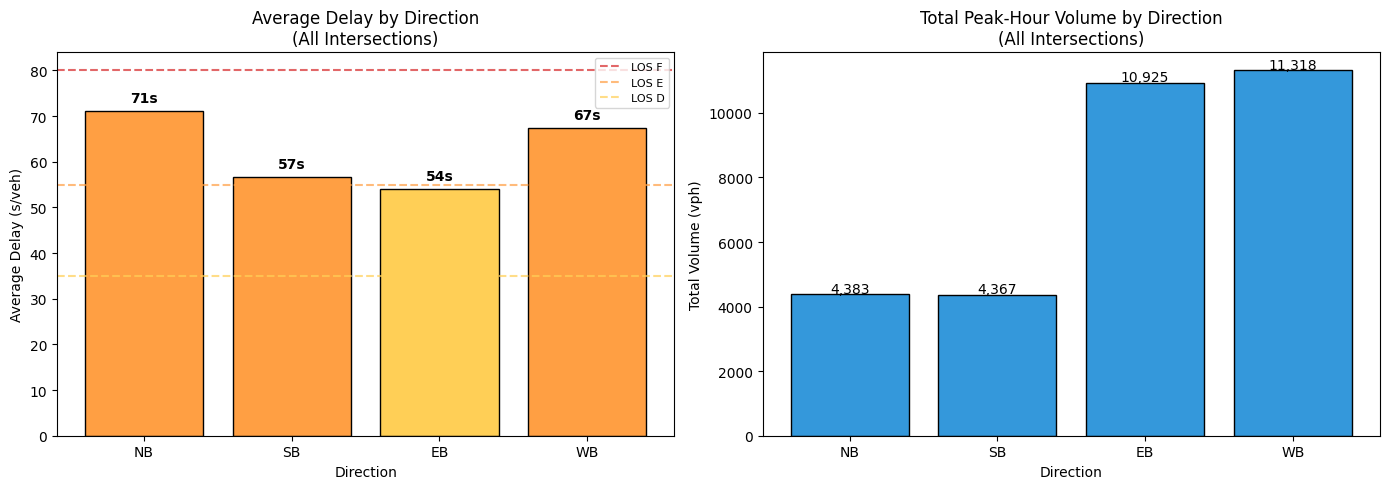


Performance by Turn Type:
           Avg Delay (s)  Avg V/C  Total Volume
turn_type                                      
L                   45.9      0.3          5383
R                   46.2      0.3          4453
T                   90.9      0.9         21157


In [19]:
def plot_direction_summary(movement_df: pd.DataFrame) -> None:
    """
    Summarize performance by direction (NB, SB, EB, WB) across all intersections.
    Helps identify if certain corridor directions are consistently problematic.
    """
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))
    
    # Aggregate by direction
    direction_agg = movement_df.groupby("direction").agg({
        "delay_s": "mean",
        "v_over_c": "mean",
        "volume_vph": "sum"
    }).round(1)
    
    # Sort by a logical compass order
    direction_order = ["NB", "SB", "EB", "WB"]
    direction_agg = direction_agg.reindex([d for d in direction_order if d in direction_agg.index])
    
    # Colors by average delay
    colors = ["#d62728" if d > 80 else "#ff9f43" if d > 55 else "#ffcf56" if d > 35 else "#2ca02c"
              for d in direction_agg["delay_s"]]
    
    # Plot 1: Average delay by direction
    ax1 = axes[0]
    bars1 = ax1.bar(direction_agg.index, direction_agg["delay_s"], color=colors, edgecolor="black")
    ax1.axhline(80, color="#d62728", linestyle="--", alpha=0.7, label="LOS F")
    ax1.axhline(55, color="#ff9f43", linestyle="--", alpha=0.7, label="LOS E")
    ax1.axhline(35, color="#ffcf56", linestyle="--", alpha=0.7, label="LOS D")
    ax1.set_ylabel("Average Delay (s/veh)")
    ax1.set_xlabel("Direction")
    ax1.set_title("Average Delay by Direction\n(All Intersections)")
    ax1.legend(fontsize=8)
    
    # Add values
    for bar, val in zip(bars1, direction_agg["delay_s"]):
        ax1.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 2, 
                 f"{val:.0f}s", ha="center", fontsize=10, fontweight="bold")
    
    # Plot 2: Total volume by direction
    ax2 = axes[1]
    bars2 = ax2.bar(direction_agg.index, direction_agg["volume_vph"], color="#3498db", edgecolor="black")
    ax2.set_ylabel("Total Volume (vph)")
    ax2.set_xlabel("Direction")
    ax2.set_title("Total Peak-Hour Volume by Direction\n(All Intersections)")
    
    for bar, val in zip(bars2, direction_agg["volume_vph"]):
        ax2.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 50, 
                 f"{val:,.0f}", ha="center", fontsize=10)
    
    plt.tight_layout()
    plt.show()
    
    # Also show by turn type
    print("\nPerformance by Turn Type:")
    turn_agg = movement_df.groupby("turn_type").agg({
        "delay_s": "mean",
        "v_over_c": "mean",
        "volume_vph": "sum"
    }).round(1)
    turn_agg.columns = ["Avg Delay (s)", "Avg V/C", "Total Volume"]
    print(turn_agg.to_string())

plot_direction_summary(movement_df)

## Improvement Recommendations Summary
Based on the analysis above, the following table summarizes intersections ranked by severity and identifies specific movements that should be prioritized for improvements.

In [20]:
def generate_improvement_summary(results: Dict[str, Any], movement_df: pd.DataFrame) -> None:
    """
    Generate a prioritized summary of improvement recommendations.
    """
    print("=" * 80)
    print("INTERSECTION IMPROVEMENT PRIORITY RANKING")
    print("=" * 80)
    
    # Rank intersections by weighted delay (delay * volume = total person-seconds of delay)
    int_summary = []
    for int_id, payload in results.get("intersections", {}).items():
        if "error" in payload:
            continue
        summary = payload["intersection"]
        total_delay_impact = summary["average_delay_s_per_veh"] * summary["total_volume_vph"]
        
        # Find worst movement
        worst_mov = max(payload.get("per_lane", []), 
                       key=lambda x: x.get("delay_s_per_veh", 0), default={})
        
        # Count oversaturated movements
        oversaturated = sum(1 for lane in payload.get("per_lane", []) 
                          if lane.get("degree_of_saturation", 0) > 1.0)
        
        int_summary.append({
            "intersection": int_id,
            "los": summary["LOS"],
            "avg_delay": summary["average_delay_s_per_veh"],
            "total_volume": summary["total_volume_vph"],
            "delay_impact": total_delay_impact,
            "worst_movement": worst_mov.get("movement", "N/A"),
            "worst_delay": worst_mov.get("delay_s_per_veh", 0),
            "oversaturated_count": oversaturated,
            "cycle_length": payload.get("cycle_length_s", 0)
        })
    
    summary_df = pd.DataFrame(int_summary).sort_values("delay_impact", ascending=False)
    
    print("\nRanked by Total Delay Impact (Delay × Volume):")
    print("-" * 80)
    print(f"{'Rank':<5} {'Intersection':<15} {'LOS':<5} {'Avg Delay':<12} {'Volume':<10} {'Worst Mov':<12} {'Oversat':<8}")
    print("-" * 80)
    
    for rank, (_, row) in enumerate(summary_df.iterrows(), 1):
        print(f"{rank:<5} {row['intersection']:<15} {row['los']:<5} "
              f"{row['avg_delay']:.1f} s/veh   {row['total_volume']:<10} "
              f"{row['worst_movement']:<12} {row['oversaturated_count']:<8}")
    
    print("\n" + "=" * 80)
    print("SPECIFIC IMPROVEMENT RECOMMENDATIONS")
    print("=" * 80)
    
    for _, row in summary_df.head(5).iterrows():
        print(f"\n📍 {row['intersection']} (LOS {row['los']}, {row['avg_delay']:.0f}s avg delay)")
        print("-" * 40)
        
        # Get movements for this intersection
        int_movements = movement_df[movement_df["intersection"] == row["intersection"]]
        problem_movements = int_movements[int_movements["v_over_c"] > 0.85].sort_values("v_over_c", ascending=False)
        
        if len(problem_movements) > 0:
            print("  ⚠️ Movements at or over capacity:")
            for _, mov in problem_movements.iterrows():
                status = "🔴 OVERSATURATED" if mov["v_over_c"] > 1.0 else "🟡 Near capacity"
                print(f"     • {mov['movement']}: v/c = {mov['v_over_c']:.2f} ({status})")
            
            print("\n  💡 Potential improvements:")
            # Suggest based on movement types
            if any(problem_movements["turn_type"] == "L"):
                print("     • Add or extend left-turn phase (protected left)")
                print("     • Consider left-turn lane capacity increase")
            if any(problem_movements["turn_type"] == "T"):
                print("     • Increase green time for through movements")
                print("     • Consider adding through lanes if ROW available")
            if row["oversaturated_count"] > 2:
                print("     • Consider signal retiming study")
                print("     • Evaluate cycle length (current: {:.0f}s)".format(row["cycle_length"]))
        else:
            print("  ✓ No movements critically oversaturated")
            print("  💡 Delay may be due to long cycle or poor progression")

generate_improvement_summary(los_results, movement_df)

INTERSECTION IMPROVEMENT PRIORITY RANKING

Ranked by Total Delay Impact (Delay × Volume):
--------------------------------------------------------------------------------
Rank  Intersection    LOS   Avg Delay    Volume     Worst Mov    Oversat 
--------------------------------------------------------------------------------
1     102_Greenhouse  F     128.1 s/veh   3312       NBT          4       
2     102_I           F     91.3 s/veh   3806       WBT          2       
3     102_Walton      F     82.4 s/veh   4107       NBL          2       
4     102_C           F     125.8 s/veh   2513       EBT          2       
5     102_A           F     100.5 s/veh   3120       EBT          2       
6     102_P           F     130.2 s/veh   2249       EBT          2       
7     102_Elm         F     94.3 s/veh   2830       WBT          2       
8     102_Been        F     80.3 s/veh   3130       WBT          1       
9     102_Moberly     F     86.3 s/veh   2483       WBT          1       
10  

## Next Steps and Interpretation Tips
- **Investigate LOS E–F** intersections first; these typically exceed 55 s/veh and indicate user discomfort.
- **Review warnings** collected in the LOS dictionaries for missing movements or zeroed lanes before trusting results.
- Adjust `DEFAULT_SATURATION_FLOW`, `plan_number`, or `aggregation` and rerun the computation cell to evaluate alternative scenarios (e.g., off-peak or actuated plans).

## Improved PM Timings Comparison

The ML optimization has generated improved timing plans for **Plan 61 (Early PM)** and **Plan 64 (PM Peak)**. 
These are stored in `data/improved_timings/` and can be loaded to compare against current timings.

Run the cells below to:
1. Load the improved timings
2. Compare LOS before and after optimization
3. Visualize the improvements

In [21]:
# Load improved timings from the ML optimization
import json
from pathlib import Path

IMPROVED_TIMINGS_DIR = Path("data/improved_timings")

def load_all_improved_timings():
    """Load all improved timing plans for PM periods."""
    results = {}
    
    if not IMPROVED_TIMINGS_DIR.exists():
        print("No improved timings found. Run ml/models/train_pm_plans.py first.")
        return results
    
    for int_dir in IMPROVED_TIMINGS_DIR.iterdir():
        if not int_dir.is_dir() or int_dir.name.startswith('.'):
            continue
        
        int_id = int_dir.name
        results[int_id] = {}
        
        for plan_file in int_dir.glob("plan_*_improved.json"):
            with open(plan_file) as f:
                data = json.load(f)
                plan_num = data.get('plan_number')
                results[int_id][plan_num] = data
    
    return results

# Load improved timings
improved_timings = load_all_improved_timings()

print(f"Loaded improved timings for {len(improved_timings)} intersections")
print("\nAvailable data:")
for int_id, plans in improved_timings.items():
    plan_nums = sorted(plans.keys())
    print(f"  {int_id}: Plans {plan_nums}")

Loaded improved timings for 10 intersections

Available data:
  102_I: Plans [61, 64]
  102_A: Plans [61, 64]
  102_Walton: Plans [61, 64]
  102_J: Plans [61, 64]
  102_C: Plans [61, 64]
  102_P: Plans [61, 64]
  102_Greenhouse: Plans [61, 64]
  102_Elm: Plans [61, 64]
  102_Moberly: Plans [61, 64]
  102_Been: Plans [61, 64]


In [22]:
# Create comparison DataFrame
comparison_records = []

for int_id, plans in improved_timings.items():
    for plan_num, data in plans.items():
        current = data.get('current_timing', {})
        improved = data.get('improved_timing', {})
        improvement = data.get('improvement', {})
        
        comparison_records.append({
            'Intersection': int_id,
            'Plan': plan_num,
            'Plan Name': data.get('plan_name', ''),
            'Time Range': data.get('time_range', ''),
            'Current Delay (s)': current.get('delay', 0),
            'Current LOS': current.get('los', 'F'),
            'Improved Delay (s)': improved.get('delay', 0),
            'Improved LOS': improved.get('los', 'F'),
            'Delay Reduction (s)': improvement.get('delay_reduction_s', 0),
            'Reduction (%)': improvement.get('delay_reduction_pct', 0),
            'Current Cycle (s)': current.get('cycle_length', 0),
            'Improved Cycle (s)': improved.get('cycle_length', 0),
        })

comparison_df = pd.DataFrame(comparison_records)
comparison_df = comparison_df.sort_values(['Plan', 'Intersection']).reset_index(drop=True)

print("="*80)
print("PM TIMING OPTIMIZATION RESULTS")
print("="*80)
print(f"\nTotal Improvements: {len(comparison_df)} plan optimizations")
print(f"Average Delay Reduction: {comparison_df['Delay Reduction (s)'].mean():.1f}s")
print(f"Total Delay Reduction: {comparison_df['Delay Reduction (s)'].sum():.1f}s")

# Show summary table
print("\n" + "-"*80)
display_cols = ['Intersection', 'Plan', 'Current Delay (s)', 'Current LOS', 
                'Improved Delay (s)', 'Improved LOS', 'Delay Reduction (s)']
print(comparison_df[display_cols].to_string(index=False))

PM TIMING OPTIMIZATION RESULTS

Total Improvements: 20 plan optimizations
Average Delay Reduction: 10.2s
Total Delay Reduction: 204.3s

--------------------------------------------------------------------------------
  Intersection  Plan  Current Delay (s) Current LOS  Improved Delay (s) Improved LOS  Delay Reduction (s)
         102_A    61             114.31           F               93.31            F                21.00
      102_Been    61              75.34           E               67.21            E                 8.13
         102_C    61             121.02           F              120.05            F                 0.97
       102_Elm    61              89.35           F               81.72            F                 7.63
102_Greenhouse    61             128.26           F              126.59            F                 1.67
         102_I    61              95.79           F               71.99            E                23.80
         102_J    61              69.70  

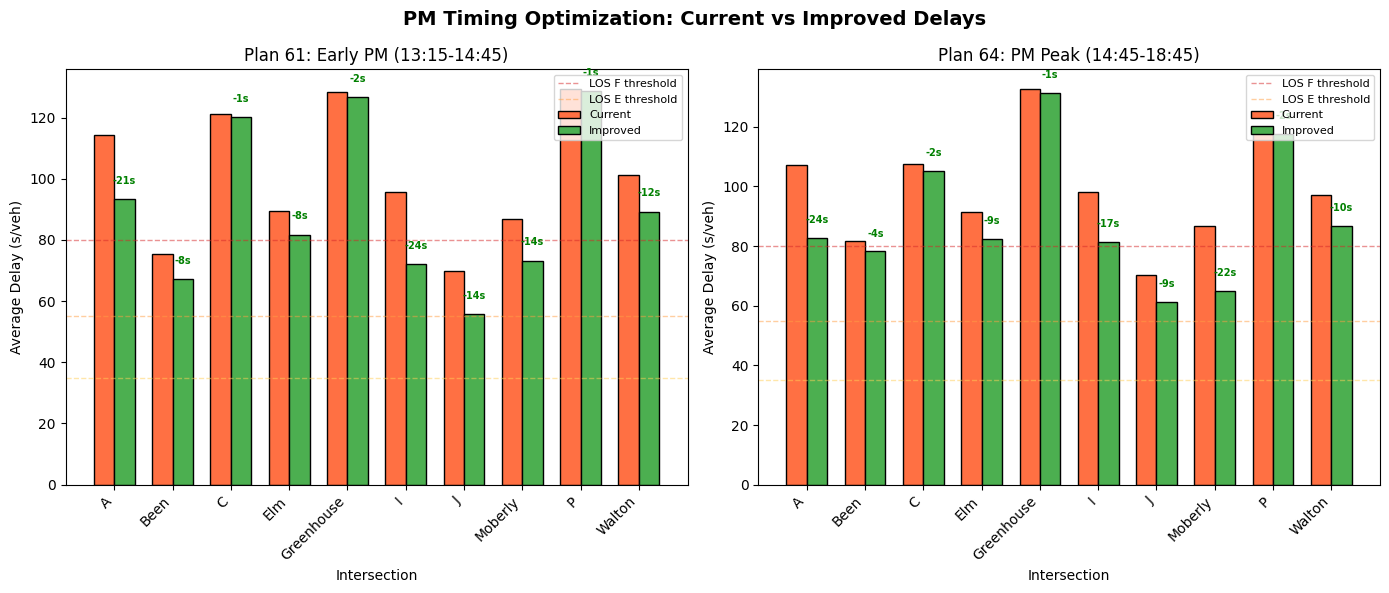


LOS Grade Changes Summary:
--------------------------------------------------
Plan 61: 2 improved LOS, 8 same LOS
Plan 64: 2 improved LOS, 8 same LOS


In [23]:
# Visualize before/after comparison
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Group by plan for easier comparison
for idx, plan_num in enumerate([61, 64]):
    ax = axes[idx]
    plan_df = comparison_df[comparison_df['Plan'] == plan_num].copy()
    
    # Shorten intersection names
    plan_df['Short Name'] = plan_df['Intersection'].str.replace('102_', '')
    
    x = np.arange(len(plan_df))
    width = 0.35
    
    # Plot current vs improved
    bars1 = ax.bar(x - width/2, plan_df['Current Delay (s)'], width, 
                   label='Current', color='#ff7043', edgecolor='black')
    bars2 = ax.bar(x + width/2, plan_df['Improved Delay (s)'], width, 
                   label='Improved', color='#4CAF50', edgecolor='black')
    
    # Add LOS grade thresholds
    ax.axhline(80, color='#d62728', linestyle='--', linewidth=1, alpha=0.5, label='LOS F threshold')
    ax.axhline(55, color='#ff9f43', linestyle='--', linewidth=1, alpha=0.5, label='LOS E threshold')
    ax.axhline(35, color='#ffcf56', linestyle='--', linewidth=1, alpha=0.5)
    
    ax.set_xlabel('Intersection')
    ax.set_ylabel('Average Delay (s/veh)')
    plan_name = "Early PM (13:15-14:45)" if plan_num == 61 else "PM Peak (14:45-18:45)"
    ax.set_title(f'Plan {plan_num}: {plan_name}')
    ax.set_xticks(x)
    ax.set_xticklabels(plan_df['Short Name'], rotation=45, ha='right')
    ax.legend(loc='upper right', fontsize=8)
    
    # Add improvement annotations
    for i, (_, row) in enumerate(plan_df.iterrows()):
        reduction = row['Delay Reduction (s)']
        ax.annotate(f'-{reduction:.0f}s', 
                    xy=(i + width/2, row['Improved Delay (s)'] + 5),
                    ha='center', fontsize=7, color='green', fontweight='bold')

plt.suptitle('PM Timing Optimization: Current vs Improved Delays', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

# Show LOS grade changes
print("\nLOS Grade Changes Summary:")
print("-"*50)
for plan_num in [61, 64]:
    plan_df = comparison_df[comparison_df['Plan'] == plan_num]
    improved_count = (plan_df['Improved LOS'] < plan_df['Current LOS']).sum()
    same_count = (plan_df['Improved LOS'] == plan_df['Current LOS']).sum()
    print(f"Plan {plan_num}: {improved_count} improved LOS, {same_count} same LOS")

In [24]:
def show_timing_changes(int_id: str, plan_num: int = 64):
    """Display detailed timing changes for a specific intersection and plan."""
    if int_id not in improved_timings or plan_num not in improved_timings[int_id]:
        print(f"No improved timing for {int_id} Plan {plan_num}")
        return
    
    data = improved_timings[int_id][plan_num]
    current = data['current_timing']
    improved = data['improved_timing']
    
    print(f"\n{'='*70}")
    print(f"DETAILED TIMING CHANGES: {int_id} - Plan {plan_num}")
    print(f"Time Period: {data['time_range']}")
    print(f"{'='*70}")
    
    print(f"\n{'Phase':<15} {'Current (s)':<15} {'Improved (s)':<15} {'Change (s)':<15}")
    print("-"*60)
    
    current_greens = current.get('phase_greens', {})
    improved_greens = improved.get('phase_greens', {})
    
    for phase in sorted(current_greens.keys()):
        curr = current_greens.get(phase, 0)
        imp = improved_greens.get(phase, curr)
        change = imp - curr
        change_str = f"+{change:.0f}" if change > 0 else f"{change:.0f}" if change < 0 else "0"
        print(f"{phase:<15} {curr:<15.0f} {imp:<15.0f} {change_str:<15}")
    
    print("-"*60)
    print(f"\nCycle Length: {current['cycle_length']:.0f}s → {improved['cycle_length']:.0f}s")
    print(f"Average Delay: {current['delay']:.1f}s → {improved['delay']:.1f}s")
    print(f"LOS: {current['los']} → {improved['los']}")
    print(f"Improvement: {data['improvement']['delay_reduction_s']:.1f}s ({data['improvement']['delay_reduction_pct']:.1f}%)")


def plot_timing_changes(int_id: str, plan_num: int = 64):
    """Visualize timing changes as a modern styled pandas DataFrame."""
    from IPython.display import display, HTML
    
    if int_id not in improved_timings or plan_num not in improved_timings[int_id]:
        print(f"No improved timing for {int_id} Plan {plan_num}")
        return
    
    data = improved_timings[int_id][plan_num]
    current = data['current_timing']
    improved = data['improved_timing']
    improvement = data['improvement']
    
    current_greens = current.get('phase_greens', {})
    improved_greens = improved.get('phase_greens', {})
    
    # Prepare table data
    phases = sorted(current_greens.keys())
    rows = []
    for phase in phases:
        curr = current_greens.get(phase, 0)
        imp = improved_greens.get(phase, curr)
        change = imp - curr
        rows.append({
            'Phase': phase,
            'Current (s)': int(curr),
            'Improved (s)': int(imp),
            'Change': f"+{int(change)}" if change > 0 else str(int(change)) if change < 0 else "0"
        })
    
    df = pd.DataFrame(rows)
    
    # Create styled HTML with modern look
    plan_name = "Early PM (13:15-14:45)" if plan_num == 61 else "PM Peak (14:45-18:45)"
    
    def style_change(val):
        if isinstance(val, str):
            if val.startswith('+'):
                return 'color: #10b981; font-weight: 600;'
            elif val.startswith('-') and val != '0':
                return 'color: #ef4444; font-weight: 600;'
        return ''
    
    # Apply pandas styling
    styled = df.style\
        .set_table_styles([
            {'selector': 'th', 'props': [
                ('background-color', '#0f172a'),
                ('color', 'white'),
                ('font-weight', '700'),
                ('padding', '14px 18px'),
                ('text-align', 'center'),
                ('font-size', '14px'),
                ('border', 'none'),
                ('letter-spacing', '0.3px')
            ]},
            {'selector': 'td', 'props': [
                ('padding', '12px 18px'),
                ('text-align', 'center'),
                ('font-size', '13px'),
                ('border-bottom', '1px solid #cbd5e1'),
                ('background-color', '#fafafa'),
                ('color', '#0f172a')
            ]},
            {'selector': 'tr:nth-child(even) td', 'props': [
                ('background-color', '#e5e7eb')
            ]},
            {'selector': 'tr:hover td', 'props': [
                ('background-color', '#d1d5db')
            ]},
            {'selector': 'table', 'props': [
                ('border-collapse', 'collapse'),
                ('border-radius', '8px'),
                ('overflow', 'hidden'),
                ('box-shadow', '0 4px 8px rgba(0,0,0,0.18)'),
                ('margin', '0 auto'),
                ('background-color', '#fafafa'),
                ('border', '2px solid #94a3b8')
            ]},
        ])\
        .map(style_change, subset=['Change'])\
        .hide(axis='index')
    
    # Summary HTML with background
    delay_color = '#10b981' if improvement['delay_reduction_s'] > 0 else '#64748b'
    
    # Full card HTML with background wrapper
    full_html = f"""
    <div style="background: linear-gradient(135deg, #cbd5e1 0%, #94a3b8 100%); padding: 24px; border-radius: 12px; margin: 16px 0; font-family: -apple-system, BlinkMacSystemFont, 'Segoe UI', Roboto, sans-serif; box-shadow: 0 6px 12px rgba(0,0,0,0.15);">
        <div style="text-align: center; margin-bottom: 20px;">
            <h3 style="margin: 0; color: #0f172a; font-size: 20px; font-weight: 700;">
                {int_id} — Plan {plan_num}
            </h3>
            <p style="margin: 6px 0 0 0; color: #334155; font-size: 14px;">
                {plan_name}
            </p>
        </div>
        
        <div style="background: #fafafa; border-radius: 8px; padding: 16px; box-shadow: 0 3px 6px rgba(0,0,0,0.12); display: flex; justify-content: center; border: 2px solid #94a3b8;">
            {styled.to_html()}
        </div>
        
        <div style="display: flex; justify-content: center; gap: 16px; margin-top: 20px; flex-wrap: wrap;">
            <div style="text-align: center; padding: 14px 24px; background: #fafafa; border-radius: 8px; box-shadow: 0 2px 4px rgba(0,0,0,0.1); min-width: 120px; border: 1px solid #94a3b8;">
                <div style="font-size: 11px; color: #334155; text-transform: uppercase; letter-spacing: 0.5px; margin-bottom: 4px; font-weight: 600;">Delay</div>
                <div style="font-size: 16px; font-weight: 600; color: #0f172a;">{current['delay']:.1f}s → {improved['delay']:.1f}s</div>
            </div>
            <div style="text-align: center; padding: 14px 24px; background: #fafafa; border-radius: 8px; box-shadow: 0 2px 4px rgba(0,0,0,0.1); min-width: 80px; border: 1px solid #94a3b8;">
                <div style="font-size: 11px; color: #334155; text-transform: uppercase; letter-spacing: 0.5px; margin-bottom: 4px; font-weight: 600;">LOS</div>
                <div style="font-size: 16px; font-weight: 600; color: #0f172a;">{current['los']} → {improved['los']}</div>
            </div>
            <div style="text-align: center; padding: 14px 24px; background: linear-gradient(135deg, #d1fae5 0%, #a7f3d0 100%); border-radius: 8px; box-shadow: 0 2px 4px rgba(0,0,0,0.1); min-width: 140px; border: 1px solid #34d399;">
                <div style="font-size: 11px; color: #065f46; text-transform: uppercase; letter-spacing: 0.5px; margin-bottom: 4px; font-weight: 700;">Improvement</div>
                <div style="font-size: 16px; font-weight: 700; color: {delay_color};">-{improvement['delay_reduction_s']:.1f}s ({improvement['delay_reduction_pct']:.1f}%)</div>
            </div>
        </div>
    </div>
    """
    
    display(HTML(full_html))


# ============================================================
# EXPLICIT TIMING CHANGES FOR REQUESTED INTERSECTIONS. 
# ============================================================

# Note: Keys match directory names in data/improved_timings/
requested_intersections = ['102_Greenhouse', '102_Walton', '102_I']
plans_to_show = [61, 64]

print("="*80)
print("TIMING CHANGES FOR REQUESTED INTERSECTIONS")
print("="*80)

for int_id in requested_intersections:
    for plan_num in plans_to_show:
        plot_timing_changes(int_id, plan_num)

TIMING CHANGES FOR REQUESTED INTERSECTIONS


Phase,Current (s),Improved (s),Change
1.0,20,18,-2
2.0,65,59,-6
4.0,20,18,-2
5.0,15,14,-1
6.0,70,63,-7
8.0,35,32,-3


Phase,Current (s),Improved (s),Change
1.0,20,18,-2
2.0,65,59,-6
4.0,20,18,-2
5.0,15,14,-1
6.0,70,63,-7
8.0,35,32,-3


Phase,Current (s),Improved (s),Change
1NBLT,17,13,-4
2SB,39,29,-10
3EBLT,18,14,-4
4WB,66,84,+18
5SBLT,16,12,-4
6NB,40,46,+6
7WBLT,15,13,-2
8EB,69,69,0


Phase,Current (s),Improved (s),Change
1NBLT,17,13,-4
2SB,39,34,-5
3EBLT,18,14,-4
4WB,66,79,+13
5SBLT,16,12,-4
6NB,40,46,+6
7WBLT,15,13,-2
8EB,69,69,0


Phase,Current (s),Improved (s),Change
1WBLT,20,16,-4
2EB,71,84,+13
3NB,19,15,-4
4SB,30,25,-5
5EBLT,15,13,-2
6WB,76,88,+12
7SBLT,17,13,-4
8NBLT,32,26,-6


Phase,Current (s),Improved (s),Change
1WBLT,20,16,-4
2EB,71,83,+12
3NB,19,15,-4
4SB,30,26,-4
5EBLT,15,13,-2
6WB,76,90,+14
7SBLT,17,13,-4
8NBLT,32,24,-8


## Deep Dive: Current vs Improved Timing Analysis

This section provides detailed movement-level breakdowns comparing **current timing** vs **improved timing** for selected intersections. We visualize:
- Control delay by movement (current vs improved)
- Volume/Capacity ratios
- Phase green time changes

DEEP DIVE: CURRENT vs IMPROVED TIMING ANALYSIS



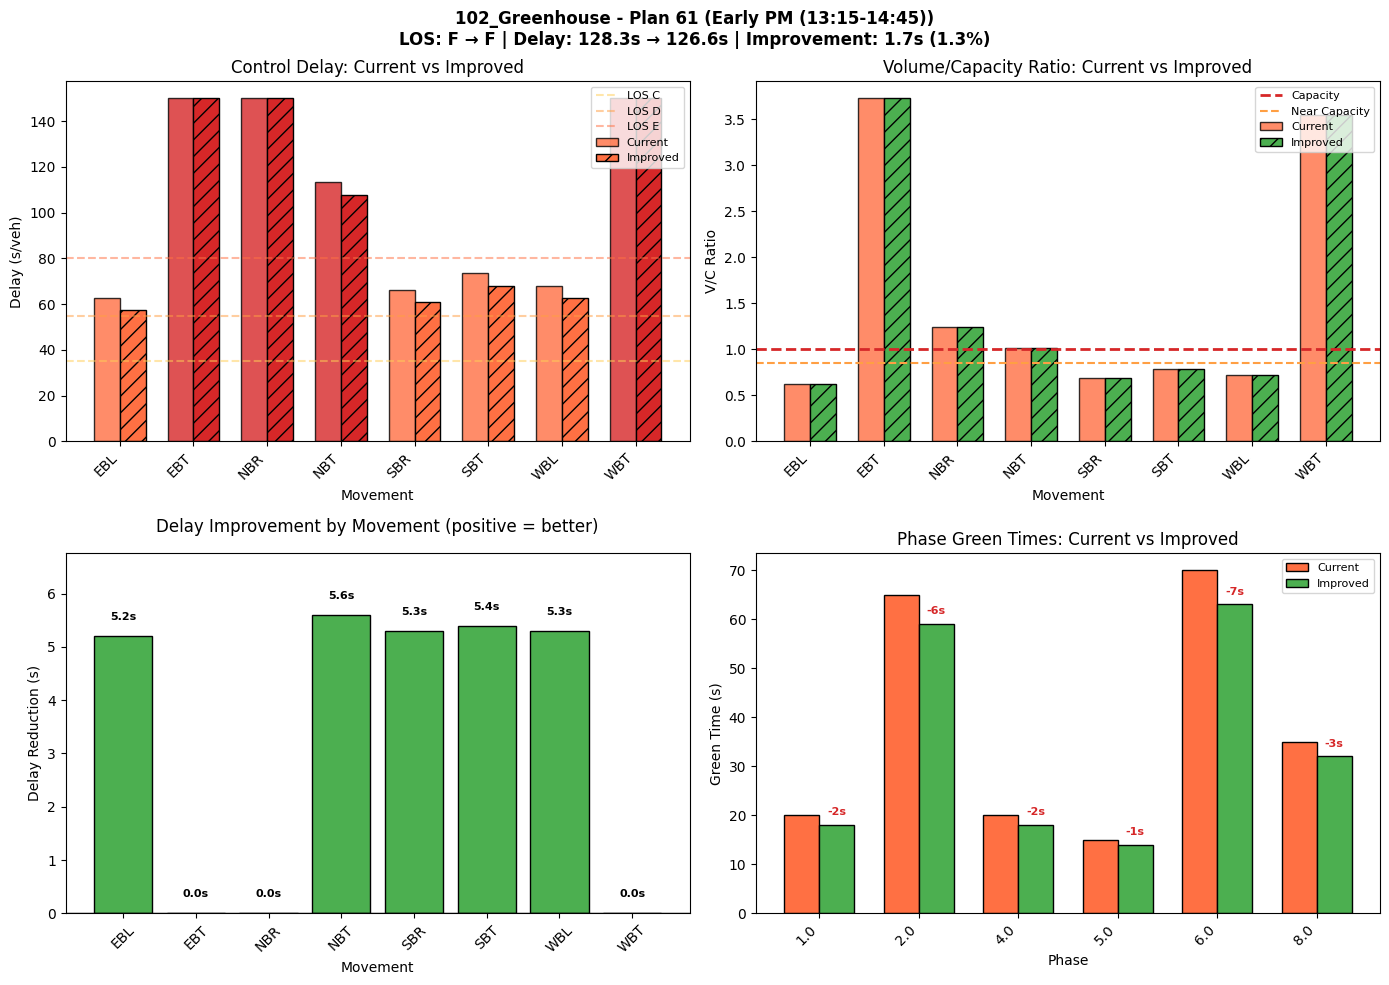


Movement   Vol (vph)    Current Delay   Improved Delay  Change     Current LOS  Improved LOS
-----------------------------------------------------------------------------------------------
EBL        177          62.5            57.3            5.2+++++++ E            E           
EBT        1063         150.0           150.0           0.0+++++++ F            F           
NBR        356          150.0           150.0           0.0+++++++ F            F           
NBT        289          113.5           107.9           5.6+++++++ F            F           
SBR        197          66.3            61.0            5.3+++++++ E            E           
SBT        224          73.5            68.1            5.4+++++++ E            E           
WBL        205          68.1            62.8            5.3+++++++ E            E           
WBT        1011         150.0           150.0           0.0+++++++ F            F           



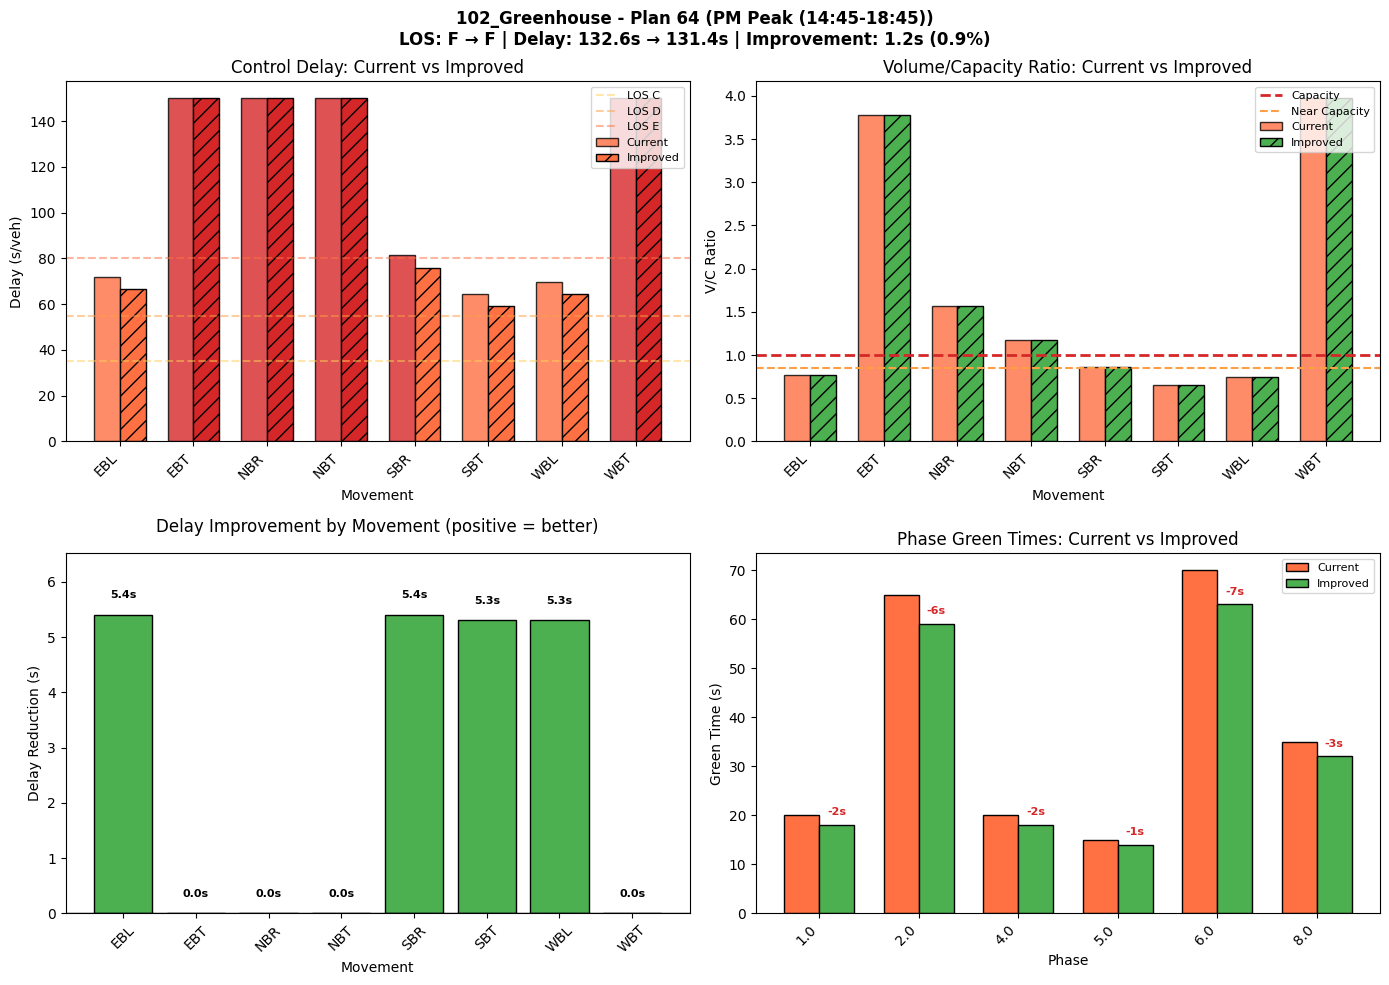


Movement   Vol (vph)    Current Delay   Improved Delay  Change     Current LOS  Improved LOS
-----------------------------------------------------------------------------------------------
EBL        219          72.0            66.6            5.4+++++++ E            E           
EBT        1075         150.0           150.0           0.0+++++++ F            F           
NBR        447          150.0           150.0           0.0+++++++ F            F           
NBT        336          150.0           150.0           0.0+++++++ F            F           
SBR        244          81.4            76.0            5.4+++++++ F            E           
SBT        187          64.3            59.0            5.3+++++++ E            E           
WBL        212          69.8            64.5            5.3+++++++ E            E           
WBT        1132         150.0           150.0           0.0+++++++ F            F           



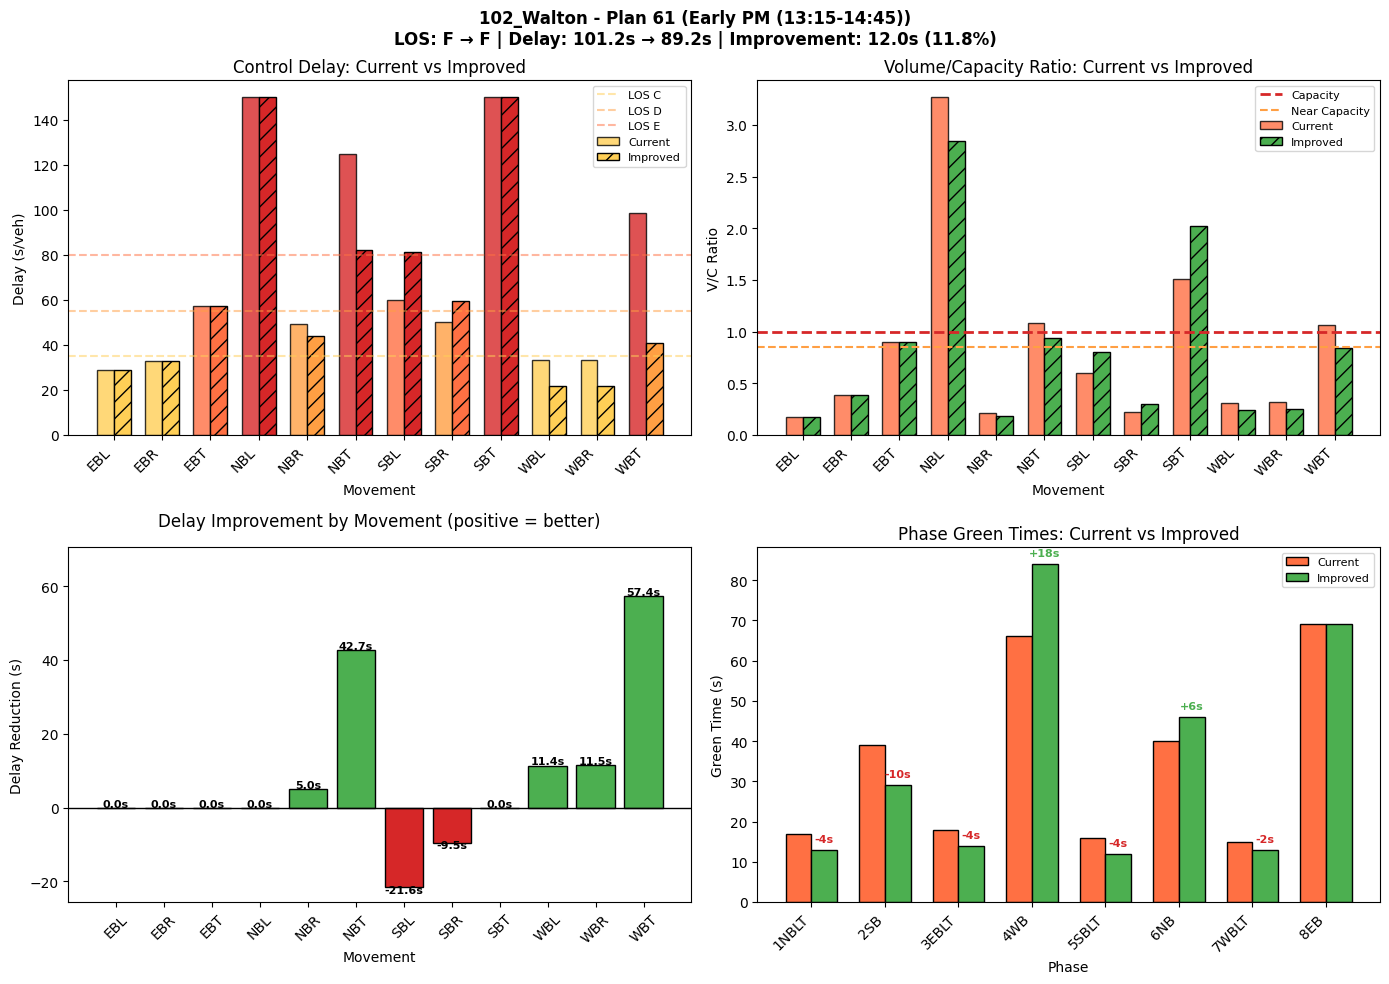


Movement   Vol (vph)    Current Delay   Improved Delay  Change     Current LOS  Improved LOS
-----------------------------------------------------------------------------------------------
EBL        140          28.8            28.8            0.0+++++++ C            C           
EBR        316          32.9            32.9            0.0+++++++ C            C           
EBT        729          57.2            57.2            0.0+++++++ E            E           
NBL        1544         150.0           150.0           0.0+++++++ F            F           
NBR        101          49.1            44.1            5.0+++++++ D            D           
NBT        509          124.9           82.2            42.7++++++ F            F           
SBL        276          59.8            81.4            -21.6+++++ E            F           
SBR        101          49.9            59.4            -9.5++++++ D            E           
SBT        693          150.0           150.0           0.0+++++++

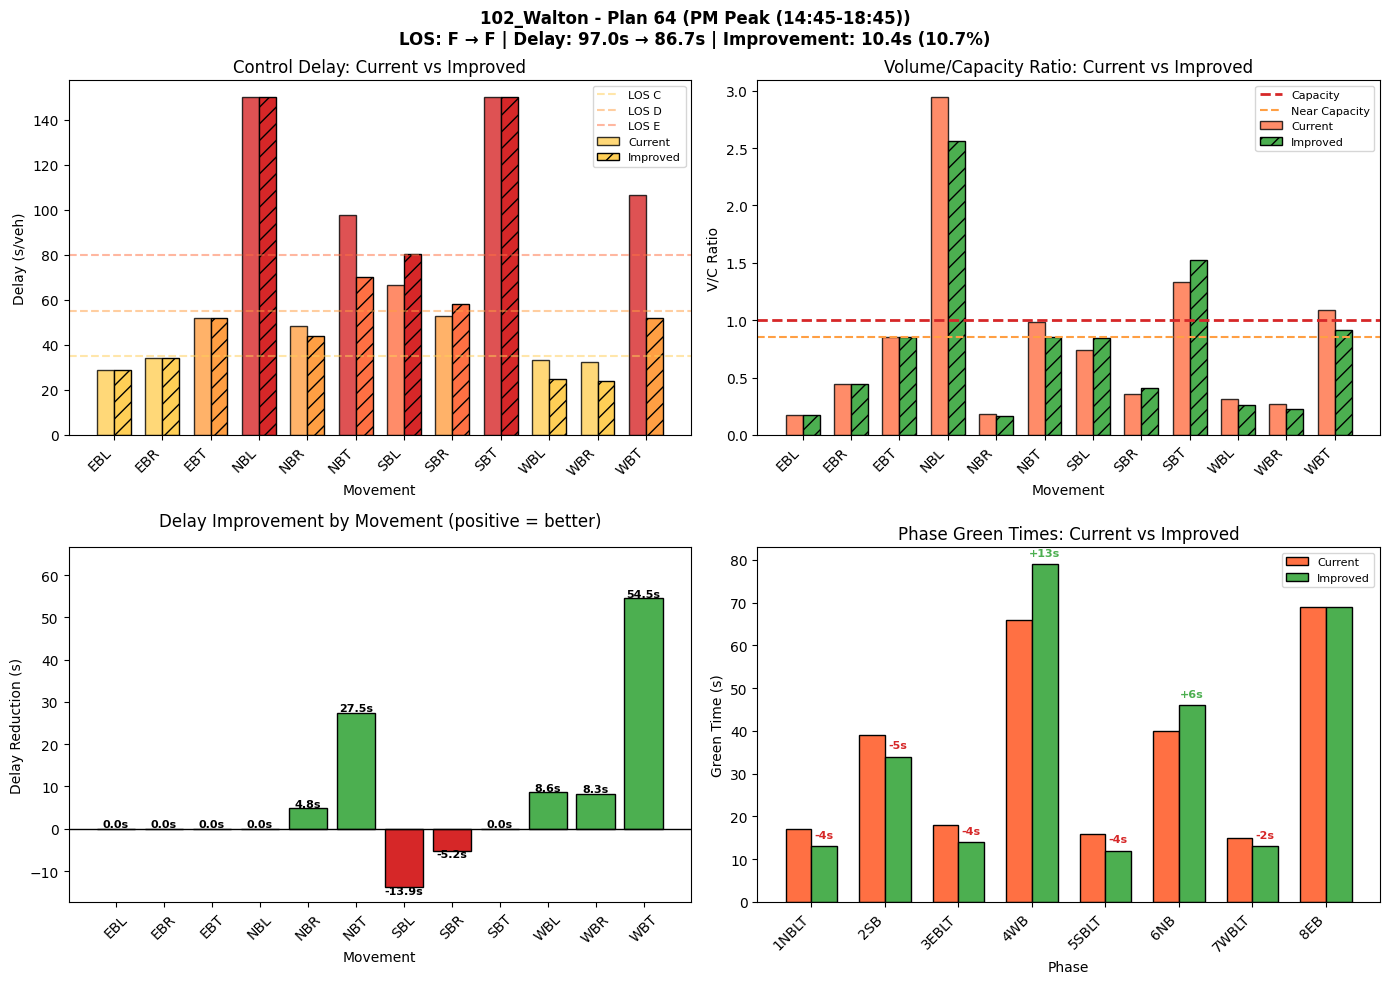


Movement   Vol (vph)    Current Delay   Improved Delay  Change     Current LOS  Improved LOS
-----------------------------------------------------------------------------------------------
EBL        140          28.8            28.8            0.0+++++++ C            C           
EBR        359          34.1            34.1            0.0+++++++ C            C           
EBT        691          52.1            52.1            0.0+++++++ D            D           
NBL        1390         150.0           150.0           0.0+++++++ F            F           
NBR        87           48.5            43.7            4.8+++++++ D            D           
NBT        464          97.6            70.1            27.5++++++ F            E           
SBL        340          66.5            80.4            -13.9+++++ E            F           
SBR        164          52.7            57.9            -5.2++++++ D            E           
SBT        612          150.0           150.0           0.0+++++++

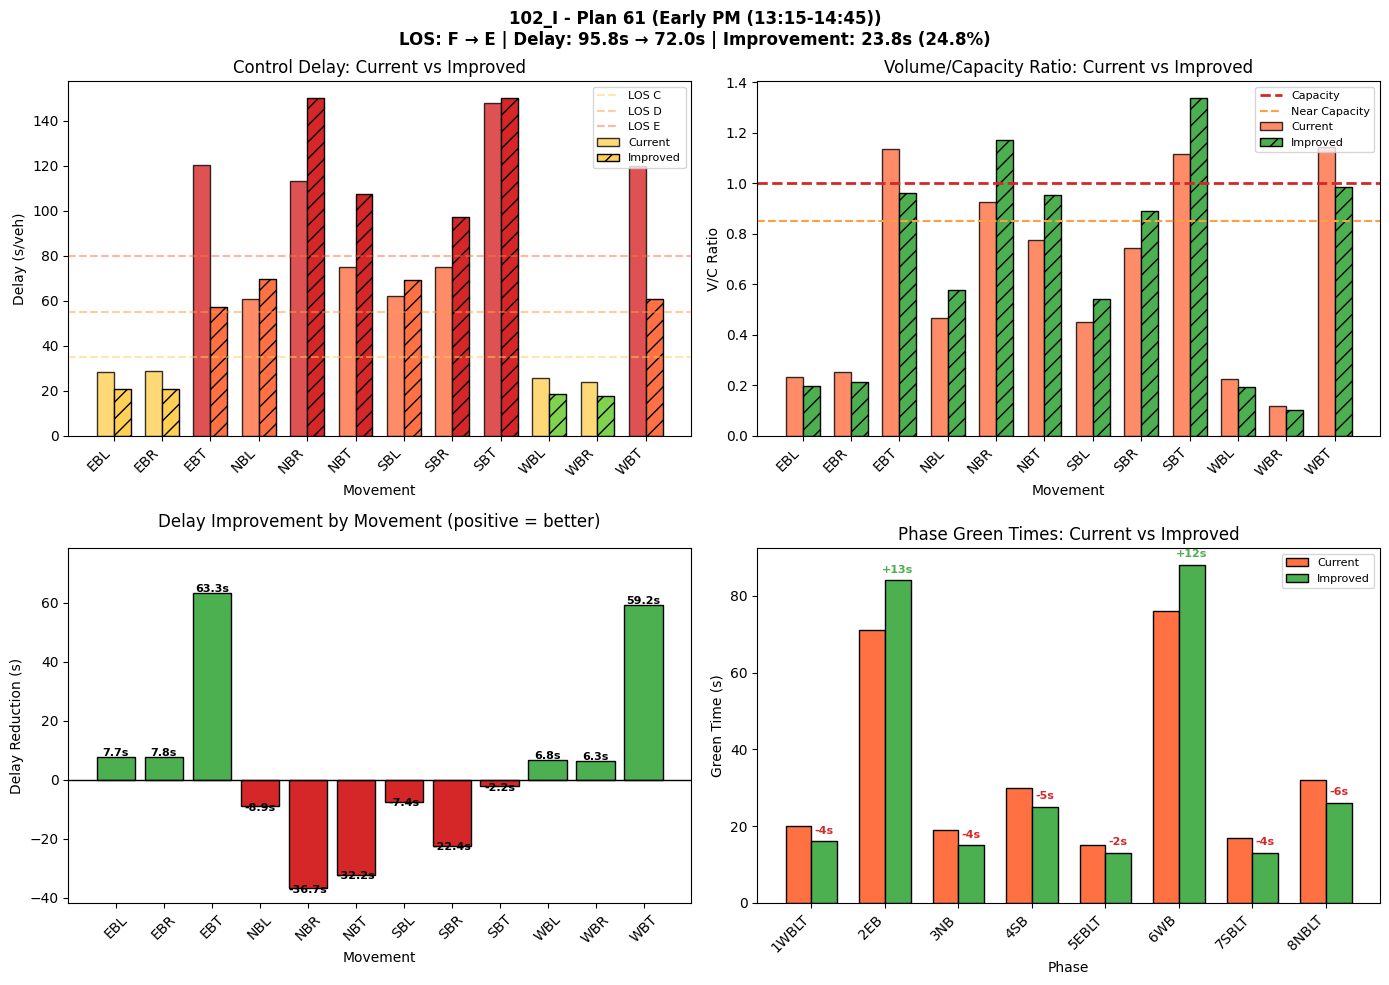


Movement   Vol (vph)    Current Delay   Improved Delay  Change     Current LOS  Improved LOS
-----------------------------------------------------------------------------------------------
EBL        196          28.5            20.8            7.7+++++++ C            C           
EBR        212          28.8            21.0            7.8+++++++ C            C           
EBT        955          120.4           57.1            63.3++++++ F            E           
NBL        177          60.9            69.8            -8.9++++++ E            E           
NBR        208          113.3           150.0           -36.7+++++ F            F           
NBT        293          75.1            107.3           -32.2+++++ E            F           
SBL        160          62.0            69.4            -7.4++++++ E            E           
SBR        264          74.8            97.2            -22.4+++++ E            F           
SBT        396          147.8           150.0           -2.2++++++

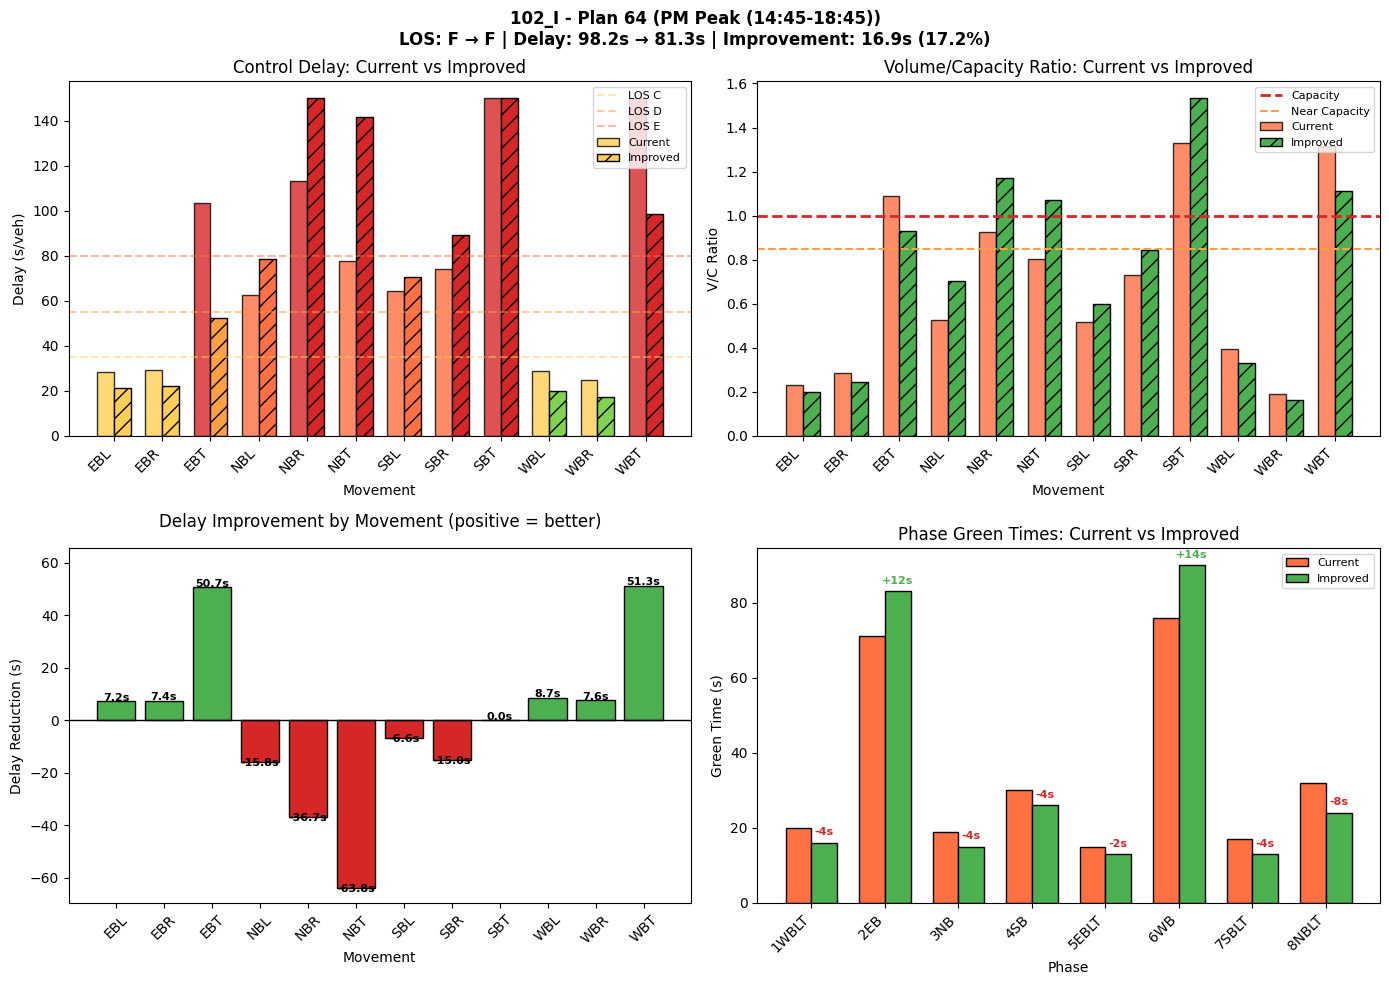


Movement   Vol (vph)    Current Delay   Improved Delay  Change     Current LOS  Improved LOS
-----------------------------------------------------------------------------------------------
EBL        196          28.5            21.3            7.2+++++++ C            C           
EBR        240          29.4            22.0            7.4+++++++ C            C           
EBT        916          103.2           52.5            50.7++++++ F            D           
NBL        200          62.7            78.5            -15.8+++++ E            E           
NBR        208          113.3           150.0           -36.7+++++ F            F           
NBT        304          77.6            141.4           -63.8+++++ E            F           
SBL        184          64.1            70.7            -6.6++++++ E            E           
SBR        260          74.0            89.0            -15.0+++++ E            F           
SBT        472          150.0           150.0           0.0+++++++

In [25]:
def plot_improved_intersection_breakdown(
    int_id: str, 
    plan_num: int = 64,
    improved_timings: Dict = None,
    los_wrapper = None
) -> None:
    """
    Create a detailed breakdown comparing CURRENT vs IMPROVED timing
    for a single intersection, showing delay and v/c ratio for each movement.
    
    Args:
        int_id: Intersection ID (e.g., '102_Greenhouse')
        plan_num: Plan number (61 or 64)
        improved_timings: Dict of improved timing data
        los_wrapper: LOSWrapper instance for recalculating metrics
    """
    if int_id not in improved_timings or plan_num not in improved_timings[int_id]:
        print(f"No improved timing data for {int_id} Plan {plan_num}")
        return
    
    data = improved_timings[int_id][plan_num]
    current_timing = data['current_timing']
    improved_timing = data['improved_timing']
    volumes = data.get('volumes_used', {})
    
    # Skip if no volumes
    if not volumes:
        print(f"No volume data for {int_id}")
        return
    
    # Create LOSWrapper if not provided
    if los_wrapper is None:
        from ml.los_wrapper import LOSWrapper
        los_wrapper = LOSWrapper()
    
    # Evaluate CURRENT timing
    current_eval = los_wrapper.evaluate_timing_plan(
        volumes=volumes,
        cycle_length=current_timing['cycle_length'],
        phase_greens=current_timing['phase_greens']
    )
    
    # Evaluate IMPROVED timing
    improved_eval = los_wrapper.evaluate_timing_plan(
        volumes=volumes,
        cycle_length=improved_timing['cycle_length'],
        phase_greens=improved_timing['phase_greens']
    )
    
    # Create DataFrames for comparison
    current_df = pd.DataFrame(current_eval['per_lane']).sort_values('movement')
    improved_df = pd.DataFrame(improved_eval['per_lane']).sort_values('movement')
    
    # Merge for comparison
    merged = current_df.merge(
        improved_df, 
        on='movement', 
        suffixes=('_current', '_improved')
    )
    
    # Color palette based on LOS
    los_colors = {
        "A": "#2ca02c", "B": "#7fd34e", "C": "#ffcf56",
        "D": "#ff9f43", "E": "#ff7043", "F": "#d62728"
    }
    
    fig, axes = plt.subplots(2, 2, figsize=(14, 10))
    
    # ================================================================
    # Plot 1: Delay Comparison (Current vs Improved)
    # ================================================================
    ax1 = axes[0, 0]
    x = np.arange(len(merged))
    width = 0.35
    
    current_colors = [los_colors.get(los, "#999999") for los in merged["LOS_current"]]
    improved_colors = [los_colors.get(los, "#999999") for los in merged["LOS_improved"]]
    
    bars1 = ax1.bar(x - width/2, merged["delay_s_per_veh_current"], width, 
                    label='Current', color=current_colors, edgecolor='black', alpha=0.8)
    bars2 = ax1.bar(x + width/2, merged["delay_s_per_veh_improved"], width, 
                    label='Improved', color=improved_colors, edgecolor='black', hatch='//')
    
    # Add LOS threshold lines
    ax1.axhline(35, color="#ffcf56", linestyle="--", alpha=0.5, label="LOS C")
    ax1.axhline(55, color="#ff9f43", linestyle="--", alpha=0.5, label="LOS D")
    ax1.axhline(80, color="#ff7043", linestyle="--", alpha=0.5, label="LOS E")
    
    ax1.set_ylabel("Delay (s/veh)")
    ax1.set_xlabel("Movement")
    ax1.set_title("Control Delay: Current vs Improved")
    ax1.set_xticks(x)
    ax1.set_xticklabels(merged["movement"], rotation=45, ha='right')
    ax1.legend(loc='upper right', fontsize=8)
    
    # ================================================================
    # Plot 2: V/C Ratio Comparison
    # ================================================================
    ax2 = axes[0, 1]
    
    bars3 = ax2.bar(x - width/2, merged["degree_of_saturation_current"], width, 
                    label='Current', color='#ff7043', edgecolor='black', alpha=0.8)
    bars4 = ax2.bar(x + width/2, merged["degree_of_saturation_improved"], width, 
                    label='Improved', color='#4CAF50', edgecolor='black', hatch='//')
    
    ax2.axhline(1.0, color="#d62728", linestyle="--", linewidth=2, label="Capacity")
    ax2.axhline(0.85, color="#ff9f43", linestyle="--", label="Near Capacity")
    
    ax2.set_ylabel("V/C Ratio")
    ax2.set_xlabel("Movement")
    ax2.set_title("Volume/Capacity Ratio: Current vs Improved")
    ax2.set_xticks(x)
    ax2.set_xticklabels(merged["movement"], rotation=45, ha='right')
    ax2.legend(loc='upper right', fontsize=8)
    
    # ================================================================
    # Plot 3: Delay Reduction by Movement
    # ================================================================
    ax3 = axes[1, 0]
    
    delay_reduction = merged["delay_s_per_veh_current"] - merged["delay_s_per_veh_improved"]
    colors = ['#4CAF50' if d > 0 else '#d62728' for d in delay_reduction]
    
    bars5 = ax3.bar(merged["movement"], delay_reduction, color=colors, edgecolor='black')
    ax3.axhline(0, color='black', linewidth=1)
    
    ax3.set_ylabel("Delay Reduction (s)")
    ax3.set_xlabel("Movement")
    ax3.set_title("Delay Improvement by Movement (positive = better)", pad=15)
    ax3.tick_params(axis='x', rotation=45)
    
    # Add extra top margin to prevent labels from overlapping with title
    current_ylim = ax3.get_ylim()
    ax3.set_ylim(current_ylim[0], current_ylim[1] * 1.15)
    
    # Add value labels
    for bar, val in zip(bars5, delay_reduction):
        ypos = bar.get_height() + 0.3 if bar.get_height() >= 0 else bar.get_height() - 1.5
        ax3.text(bar.get_x() + bar.get_width()/2, ypos, f"{val:.1f}s", 
                 ha='center', fontsize=8, fontweight='bold')
    
    # ================================================================
    # Plot 4: Phase Green Time Changes
    # ================================================================
    ax4 = axes[1, 1]
    
    current_greens = current_timing['phase_greens']
    improved_greens = improved_timing['phase_greens']
    
    phases = sorted(current_greens.keys())
    current_vals = [current_greens.get(p, 0) for p in phases]
    improved_vals = [improved_greens.get(p, 0) for p in phases]
    
    x_phases = np.arange(len(phases))
    
    bars6 = ax4.bar(x_phases - width/2, current_vals, width, 
                    label='Current', color='#ff7043', edgecolor='black')
    bars7 = ax4.bar(x_phases + width/2, improved_vals, width, 
                    label='Improved', color='#4CAF50', edgecolor='black')
    
    ax4.set_ylabel("Green Time (s)")
    ax4.set_xlabel("Phase")
    ax4.set_title("Phase Green Times: Current vs Improved")
    ax4.set_xticks(x_phases)
    ax4.set_xticklabels(phases, rotation=45, ha='right')
    ax4.legend(loc='upper right', fontsize=8)
    
    # Add change annotations
    for i, (curr, imp) in enumerate(zip(current_vals, improved_vals)):
        change = imp - curr
        if change != 0:
            color = '#4CAF50' if change > 0 else '#d62728'
            sign = '+' if change > 0 else ''
            ax4.annotate(f"{sign}{change:.0f}s", 
                        xy=(i + width/2, imp + 2),
                        ha='center', fontsize=8, color=color, fontweight='bold')
    
    # Overall title with summary
    current_summary = current_eval['intersection']
    improved_summary = improved_eval['intersection']
    improvement = data['improvement']
    
    plan_name = "Early PM (13:15-14:45)" if plan_num == 61 else "PM Peak (14:45-18:45)"
    
    fig.suptitle(
        f"{int_id} - Plan {plan_num} ({plan_name})\n"
        f"LOS: {current_summary['LOS']} → {improved_summary['LOS']} | "
        f"Delay: {current_summary['average_delay_s_per_veh']:.1f}s → {improved_summary['average_delay_s_per_veh']:.1f}s | "
        f"Improvement: {improvement['delay_reduction_s']:.1f}s ({improvement['delay_reduction_pct']:.1f}%)",
        fontsize=12, fontweight='bold'
    )
    
    plt.tight_layout()
    plt.show()
    
    # Print detailed movement table
    print(f"\n{'Movement':<10} {'Vol (vph)':<12} {'Current Delay':<15} {'Improved Delay':<15} {'Change':<10} {'Current LOS':<12} {'Improved LOS':<12}")
    print("-" * 95)
    for _, row in merged.iterrows():
        change = row['delay_s_per_veh_current'] - row['delay_s_per_veh_improved']
        print(f"{row['movement']:<10} {row['volume_vph_current']:<12.0f} "
              f"{row['delay_s_per_veh_current']:<15.1f} {row['delay_s_per_veh_improved']:<15.1f} "
              f"{change:+<10.1f} {row['LOS_current']:<12} {row['LOS_improved']:<12}")


# ============================================================
# Generate detailed breakdowns for selected intersections
# ============================================================
from ml.los_wrapper import LOSWrapper

los_wrapper = LOSWrapper()

print("="*80)
print("DEEP DIVE: CURRENT vs IMPROVED TIMING ANALYSIS")
print("="*80)

# Analyze these three intersections for both PM plans
target_intersections = ['102_Greenhouse', '102_Walton', '102_I']

for int_id in target_intersections:
    for plan_num in [61, 64]:
        print(f"\n{'='*80}")
        plot_improved_intersection_breakdown(int_id, plan_num, improved_timings, los_wrapper)